In [1]:
#load neccesary packages
using CSV
using DataFrames
using Plots
using Statistics
using StatsPlots
using RDatasets
using Combinatorics
using HypothesisTests
using StatsBase
using VegaLite
using Distances
using Distributed
addprocs(7)
using Eirene   
@everywhere using SharedArrays


@everywhere push!(LOAD_PATH, $"E:functions/") 
@everywhere using cElegansFunctions
@everywhere using RCall


@everywhere R"library(TDA)"

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-13170384587329148168\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-12459878090760114824\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-13170384587329148168\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

[ Info: waiting for lock on pidfile at "C:\Users\alech\.jlassetregistry.lock"
[ Info: waiting for lock on pidfile at "C:\Users\alech\.jlassetregistry.lock"
[ Info: waiting for lock on pidfile at "C:\Users\alech\.jlassetregistry.lock"
[ Info: waiting for lock on pidfile at "C:\Users\alech\.jlassetregistry.lock"
[ Info: waiting for lock on pidfile at "C:\Users\alech\.jlassetregistry.lock"
[ Info: waiting for lock on pidfile at "C:\Users\alech\.jlassetregistry.lock"
┌ Warning: Error requiring WebSockets from WebIO:
│ LoadError: IOError: open: operation not permitted (EPERM)
│ Stacktrace:
│  [1] uv_error at .\libuv.jl:85 [inlined]
│  [2] open(::String, ::UInt16, ::UInt16) at .\filesystem.jl:81
│  [3] tryopen_exclusive(::String, ::UInt16) at C:\Users\alech\.julia\packages\Pidfile\q0iHJ\src\Pidfile.jl:152
│  [4] #open_exclusive#4(::UInt16, ::Int64, ::Int64, ::Function, ::String) at C:\Users\alech\.julia\packages\Pidfile\q0iHJ\src\Pidfile.jl:185
│  [5] #open_exclusive at .\none:0 [inlined]
│ 


R version 3.6.1 (2019-07-05) -- "Action of the Toes"
Copyright (C) 2019 The R Foundation for Statistical Computing
Platform: x86_64-w64-mingw32/x64 (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.




R version 3.6.1 (2019-07-05) -- "Action of the Toes"
Copyright (C) 2019 The R Foundation for Statistical Computing
Platform: x86_64-w64-mingw32/x64 (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

      From worker 4:	
      From worker 5:	
      From worker 5:	R version 3.6.1 (2019-07-05) -- "Action of the Toes"
      From worker 5:	Copyright (C) 2019 The R Foundation for Statistical Computing
      From worker 5:	Platform: x86_64-w64-mingw32/x64 (64-bit)
      From worker 5:	
      From worker 5:	R is free software and comes with ABSOLUTELY NO WARRANTY.

In [2]:
#load neccesary data files
positions = CSV.read("E://From Gene Expression File//279positions.csv", copycols = true, header = false)
positionsLabels = CSV.read("E://From Gene Expression File//279positionsLabels.csv", copycols = true, header = false)
birthTimes = CSV.read("E://From Gene Expression File//279birthTimes.csv", copycols = true, header = false)
birthTimesLabels = CSV.read("E://From Gene Expression File//279birthTimesLabels.csv", copycols = true, header = false)
connectionList = CSV.read("E://From Gene Expression File//NeuronConnect_corrected.csv", copycols = true, header = false)
labeledTypeList = CSV.read("E://From Gene Expression File//279labeledTypes.csv", copycols = true, header = false)
zeroDimTopSim = CSV.read("E://From Gene Expression File//dimensionZeroSimilarity.csv", copycols = true, header = false)
oneDimTopSim = CSV.read("E://From Gene Expression File//dimensionOneSimilarity.csv", copycols = true, header = false)
twoDimTopSim = CSV.read("E://From Gene Expression File//dimensionTwoSimilarity.csv", copycols = true, header = false)
zeroDimTopSimGD = CSV.read("E://From Gene Expression File//dimensionZeroMixedPairSimilarity.csv", copycols = true, header = false)
oneDimTopSimGD = CSV.read("E://From Gene Expression File//dimensionOneMixedPairSimilarity.csv", copycols = true, header = false)
twoDimTopSimGD = CSV.read("E://From Gene Expression File//dimensionTwoMixedPairSimilarity.csv", copycols = true, header = false)


#done
println("done")

done


In [3]:
#process all the data into a single array sorted by birth time

#creates an array for positions with their labels
positionsMatrix = Array{Any, 2}(UndefInitializer(),279,3)

for i in 1:279
    positionsMatrix[i,1] = positionsLabels[1][i]
    positionsMatrix[i,2] = positions[i,1]
    positionsMatrix[i,3] = positions[i,2]
end

#creates an array for positions with their labels
birthTimesMatrix = Array{Any, 2}(UndefInitializer(),279,2)

for i in 1:279
    birthTimesMatrix[i,1] = birthTimesLabels[1][i]
    birthTimesMatrix[i,2] = birthTimes[1][i]
end

#creates an array for types with their labels
typeMatrix = Array{Any, 2}(UndefInitializer(), 279,2)

for i in 1:279
    typeMatrix[i,1] = labeledTypeList[1][i]
    typeMatrix[i,2] = labeledTypeList[2][i]
end



#sorts all the above matricies by neuron label to make them compatible
for i in 1:279
    movement = 0
    
    while i - movement > 1 && positionsMatrix[i - movement, 1] < positionsMatrix[i-movement - 1, 1]
        shadowCache = positionsMatrix[i - movement, :]
        positionsMatrix[i - movement, :] = positionsMatrix[i - movement - 1, :]
        positionsMatrix[i - movement - 1, :] = shadowCache
        
        movement += 1
    end
    
    movement = 0
    
    while i - movement > 1 && birthTimesMatrix[i - movement, 1] < birthTimesMatrix[i-movement - 1, 1]
        shadowCache = birthTimesMatrix[i - movement, :]
        birthTimesMatrix[i - movement, :] = birthTimesMatrix[i - movement - 1, :]
        birthTimesMatrix[i - movement - 1, :] = shadowCache
        
        movement += 1
    end
    
    movement = 0
    
    while i - movement > 1 && typeMatrix[i - movement, 1] < typeMatrix[i-movement - 1, 1]
        shadowCache = typeMatrix[i - movement, :]
        typeMatrix[i - movement, :] = typeMatrix[i - movement - 1, :]
        typeMatrix[i - movement - 1, :] = shadowCache
        
        movement += 1
    end
end


#stores all these data points into a single concise matrix
labelsTimesPositionsType = Array{Any, 2}(UndefInitializer(),279,5)

labelsTimesPositionsType[:,1:2] = birthTimesMatrix[:,:]
labelsTimesPositionsType[:,3:4] = positionsMatrix[:,2:3]
labelsTimesPositionsType[:,5] = typeMatrix[:,2]

#alter the positions isometrically to look nicer 
labelsTimesPositionsType[:,3] *= -1
labelsTimesPositionsType[:,4] *= -1


#sorts new matrix by birth time
for i in 1:279
    movement = 0
    
    while i - movement > 1 && labelsTimesPositionsType[i - movement, 2] < labelsTimesPositionsType[i-movement - 1, 2]
        shadowCache = labelsTimesPositionsType[i - movement, :]
        labelsTimesPositionsType[i - movement, :] = labelsTimesPositionsType[i - movement - 1, :]
        labelsTimesPositionsType[i - movement - 1, :] = shadowCache
        
        movement += 1
    end
end


#processes connection list and stores that in its own matrix

connectionBase = Array{Any, 2}(UndefInitializer(),6417,4)

for i in 1:6417
    for j in 1:4
        connectionBase[i,j] = connectionList[i,j]
    end
end


#create adjacency matrix sorted by birth time weighted for a node filtered persistent homology calculation
birthSortedAdjacencyMatrix = zeros(279,279)
       
for i in 1:279
    for j in 1:279
        birthSortedAdjacencyMatrix[i,j] = 3000
    end
end

for k in 1:6417
    for i in 1:279
        for j in 1:279
            if connectionBase[k,1] == labelsTimesPositionsType[i,1] && connectionBase[k,2] == labelsTimesPositionsType[j,1]
                max = maximum([labelsTimesPositionsType[i,2],labelsTimesPositionsType[j,2]])
                birthSortedAdjacencyMatrix[i,j] = max
            end
            if connectionBase[k,1] == labelsTimesPositionsType[j,1] && connectionBase[k,2] == labelsTimesPositionsType[i,1]
                max = maximum([labelsTimesPositionsType[i,2],labelsTimesPositionsType[j,2]])
                birthSortedAdjacencyMatrix[i,j] = max
            end
        end
    end
end

#add all the mostly trivial self loops, which are neccesary for dimension 0 calculations
for i in 1:279
    birthSortedAdjacencyMatrix[i,i] = labelsTimesPositionsType[i,2]
end       





#construct an array that is a list of times at which neurons are born, and how many born at that time. also constructs a list providing the number on this list for each neuron
birthOrder = Array{Int64, 1}(undef, 279)
times = Array{Float64, 2}(undef, 2,2)
times[1,:] = [labelsTimesPositionsType[1,2],1]
birthOrder[1] = 1
times[2,:] = [labelsTimesPositionsType[2,2],1]
birthOrder[2] = 2
birthOrderCounter = 2

for i in 3:279
    if labelsTimesPositionsType[i,2] != times[end,1]
        times = cat(dims = 1, times[:,:], transpose([labelsTimesPositionsType[i,2],1]))
        birthOrderCounter += 1
    else
        times[end,2] += 1
    end
    birthOrder[i] = birthOrderCounter
end


#determine number of points on x-axis
numValues = size(times,1)

#end step
println("output: labelsTimesPositionsType, birthSortedAdjacencyMatrix, birthOrder, numValues, and times")

#cleanup
positionsMatrix = nothing
positions = nothing
positionsLabels = nothing
birthTimes = nothing
birthTimesLabels = nothing
connectionList = nothing
labeledTypeList = nothing
birthTimesMatrix = nothing
typeMatrix = nothing
connectionBase = nothing
birthOrderCounter = nothing

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[3]:7
└ @ Core .\In[3]:7
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[3]:16
└ @ Core .\In[3]:16
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[3]:17
└ @ Core .\In[3]:17
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[3]:24
└ @ Core .\In[3]:24
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[3]:25
└ @ Core .\In[3]:25


output: labelsTimesPositionsType, birthSortedAdjacencyMatrix, birthOrder, numValues, and times


In [5]:
#computes the betti curves in dimensions 0-3, and birth/death rates for each also
eireneMatrix = eirene(birthSortedAdjacencyMatrix, model = "vr", minrad = 0.5, maxrad = 3001, maxdim = 3)
 



#make arrays to store betti curves
BettiCurves = zeros(numValues,4)
BettiRates = zeros(numValues,3,2)
barcodes = barcode(eireneMatrix, dim=0)
amount = size(barcodes,1)
bettiNumber = 0


#calculate and store dimension 0 betti values
for i in 1:numValues
    
    for j in 1:amount
        if barcodes[j,1] == times[i,1]
            bettiNumber += 1
            BettiRates[i,1,1] += 1
        end
        if barcodes[j,2] == times[i,1]
            bettiNumber -= 1
            BettiRates[i,1,2] += 1
        end
    end
    BettiCurves[i,1] = bettiNumber
end


#calculate and store dimension 1 betti values (resetting variables first)
barcodes = barcode(eireneMatrix, dim=1)
amount = size(barcodes,1)
bettiNumber = 0

for i in 1:numValues
    for j in 1:amount
        if barcodes[j,1] == times[i,1]
            bettiNumber += 1
            BettiRates[i,2,1] += 1
        end
        if barcodes[j,2] == times[i,1]
            bettiNumber -= 1
            BettiRates[i,2,2] += 1
        end
    end
    BettiCurves[i,2] = bettiNumber
end

#calculate and store dimension 2 betti values (resetting variables first)
barcodes = barcode(eireneMatrix, dim=2)
amount = size(barcodes,1)
bettiNumber = 0

for i in 1:numValues
    for j in 1:amount
        if barcodes[j,1] == times[i,1]
            bettiNumber += 1
            BettiRates[i,3,1] += 1
        end
        if barcodes[j,2] == times[i,1]
            bettiNumber -= 1
            BettiRates[i,3,2] += 1
        end
    end
    BettiCurves[i,3] = bettiNumber
end


#calculate and store dimension 3 betti values (resetting variables first)
barcodes = barcode(eireneMatrix, dim=3)
amount = size(barcodes,1)
bettiNumber = 0

for i in 1:numValues
        

    for j in 1:amount
        if barcodes[j,1] == times[i,1]
            bettiNumber += 1
        end
        if barcodes[j,2] == times[i,1]
            bettiNumber -= 1
        end
    end
    BettiCurves[i,4] = bettiNumber
end

#end step
println("output: numValues, BettiCurves")

#cleanup
barcodes = nothing
bettiNumber = nothing
amount = nothing

output: numValues, BettiCurves


In [6]:
#plot of betti curves


#determine percent of neurons born with time
percentBorn = zeros(numValues)
percentCounter = 1
percentBorn[percentCounter] = 1/2.79
for i in 2:279
    if labelsTimesPositionsType[i,2] != labelsTimesPositionsType[i-1,2]
        percentCounter += 1
        percentBorn[percentCounter] += percentBorn[percentCounter-1]
    end
    percentBorn[percentCounter] += 1/2.79  
end

#determine edge density with time
edgeDensity = zeros(numValues,2)
edgeCounter = 0

for t in 1:numValues
    edgeCounter += trunc(Int, times[t,2])
    
    numberEdges = 0

    for i in 1:edgeCounter
        for j in 1:i-1
            if birthSortedAdjacencyMatrix[i,j] < 3000
                numberEdges += 1
            end
        end
    end

    edgeDensity[t,2] = numberEdges/binomial(edgeCounter,2)
    edgeDensity[t,1] = times[t,1]
end


#do the actual plotting
p1 = plot(times[:,1], [BettiCurves[:,2], BettiCurves[:,3]], color = [:red :blue theme(:default)], title = "C Elegans Betti Curves", label = ["dim 1" "dim 2" "dim 3"], legend=:bottomright , legendfont = font(4),  xlabel = "minutes", ylabel = "betti number", xlims=(0,2400))
sticks!(1:1300, location[:], lc = :black, label = "period of no neuron birth")
p2 = plot(edgeDensity[:,1], edgeDensity[:,2], lc = [:grey], line=(:dot,2), legendfont = font(4), xlabel = "minutes", ylabel = "edge density", legend = false, label = "edge density",  xlims=(0,2400))
p3 = plot(times[:,1], percentBorn[:], lc = [:black], line=(:dot,2),  ylabel = "percent of neurons born", xlims=(0,2400), legend = false)
p4 = plot(times[:,1], [BettiCurves[:,1], BettiCurves[:,4]], color = [:green :purple theme(:default)], title = "C Elegans Betti Curves", label = ["dim 0" "dim 3"], legend=:bottomright , legendfont = font(4),  xlabel = "minutes", ylabel = "betti number", ylims = (0,10), xlims=(0,2400))


plot(p1,p4,p2,p3, layout = (4,1), size = (800,800))
#savefig("oneThroughThreeBettiCurves.pdf")

UndefVarError: UndefVarError: location not defined

In [ ]:
plotbarcode_pjs(eireneMatrix)

In [ ]:
#do the actual plotting
p1 = plot(times[:,1], BettiRates[:,1,1], color = [ :blue theme(:default)], title = "Dimension Zero", label = ["birth" ], legend=:bottomright , legendfont = font(4),  xlabel = "minutes", ylabel = "number of cavities", xlims=(0,2400))
p2 = plot(times[:,1], BettiRates[:,2,1], color = [ :blue theme(:default)], title = "Dimension One", label = ["birth" ], legend=:bottomright , legendfont = font(4),  xlabel = "minutes", ylabel = "number of cavities", xlims=(0,2400))
p3 = plot(times[:,1], BettiRates[:,3,1], color = [ :blue theme(:default)], title = "Dimension Two", label = ["birth" ], legend=:bottomright , legendfont = font(4),  xlabel = "minutes", ylabel = "number of cavities", xlims=(0,2400))

p4 = plot(times[:,1], BettiRates[:,1,2], color = [:red  theme(:default)], title = "Dimension Zero", label = ["death"], legend=:bottomright , legendfont = font(4),  xlabel = "minutes", ylabel = "number of cavities", xlims=(0,2400))
p5 = plot(times[:,1], BettiRates[:,2,2], color = [:red  theme(:default)], title = "Dimension One", label = ["death"], legend=:bottomright , legendfont = font(4),  xlabel = "minutes", ylabel = "number of cavities", xlims=(0,2400))
p6 = plot(times[:,1], BettiRates[:,3,2], color = [:red  theme(:default)], title = "Dimension Two", label = ["death"], legend=:bottomright , legendfont = font(4),  xlabel = "minutes", ylabel = "number of cavities", xlims=(0,2400))


plot(p1,p4,p2,p5,p3,p6, layout = (3,2), size = (1400,800))
#savefig("oneThroughTwoBettiRates.pdf")

In [ ]:
#post-plotting cleanup
location = nothing
percentBorn = nothing
edgeDensity = nothing
numberEdges = nothing
p1 = nothing
p2 = nothing
p3 = nothing
p4 = nothing
eireneMatrix = nothing

In [ ]:
#make 1000 models by varying birth times and adding random edges
numTrials = 1000
randomModelsWithTimes = zeros(279,280,numTrials)



#load all the models with the base
for k in 1:numTrials
    randomModelsWithTimes[:,1:279,k] = birthSortedAdjacencyMatrix[:,:]


    #reconstruct each as a binary matrix to ease calculations
    for i in 1:279
        for j in 1:279
            if randomModelsWithTimes[i,j,k] < 3000
                randomModelsWithTimes[i,j,k] = 1
            end
            if randomModelsWithTimes[i,j,k] == 3000
                randomModelsWithTimes[i,j,k] = 0
            end
        end
    end


    #for each model, add 810 random connections
    for counter in 1:810
        initial = rand(1:279)
        terminal = rand(1:279)
        while terminal == initial
            terminal = rand(1:279)
        end
        
        randomModelsWithTimes[initial,terminal,k] = 1
        randomModelsWithTimes[terminal,initial,k] = 1
    end


    #alter the birth times of each neuron
    bornTimes = labelsTimesPositionsType[:,2]

    for i in 1:201
        sign = rand()
    
        if sign < 0.5
            error = rand()
            percentError = error*0.1
            error = bornTimes[i] * percentError
            bornTimes[i] += error
        end
    
        if sign >= 0.5
            error = rand()
            percentError = error*0.1
            error = bornTimes[i] * percentError
            bornTimes[i] -= error
        end
    end

    for i in 202:279
        sign = rand()
    
        if sign < 0.5
            error = rand()
            percentError = error*0.02
            error = bornTimes[i] * percentError
            bornTimes[i] += error
        end
    
        if sign >= 0.5
            error = rand()
            percentError = error*0.02
            error = bornTimes[i] * percentError
            bornTimes[i] -= error
        end
    end
    
    #reorder the current matrix by birth time
    for i in 1:279
        movement = 0
    
        while i - movement > 1 && bornTimes[i - movement] < bornTimes[i-movement - 1]
            shadowCache = bornTimes[i - movement]
            bornTimes[i - movement] = bornTimes[i - movement - 1]
            bornTimes[i - movement - 1] = shadowCache
            
            shadowCache = randomModelsWithTimes[i - movement, :,k]
            randomModelsWithTimes[i - movement, :,k] = randomModelsWithTimes[i - movement - 1, :,k]
            randomModelsWithTimes[i - movement - 1, :,k] = shadowCache
            
            shadowCache = randomModelsWithTimes[:,i - movement, k]
            randomModelsWithTimes[:,i - movement, k] = randomModelsWithTimes[:,i - movement - 1, k]
            randomModelsWithTimes[:,i - movement - 1, k] = shadowCache
        
            movement += 1
        end
    end
    randomModelsWithTimes[:,280,k] = bornTimes[:]
    
    #re-label the random models for eirene calculations
    for i in 1:279
        for j in 1:279
            if randomModelsWithTimes[i,j,k] == 1
                randomModelsWithTimes[i,j,k] = maximum([bornTimes[i], bornTimes[j]])
            end
            if randomModelsWithTimes[i,j,k] == 0
                randomModelsWithTimes[i,j,k] = 3000
            end
        end
    end
end
println("output: randomModelsWithTimes, numTrials")

#cleanup

In [ ]:
begin
#perform computations
randomCurves = pmap(i -> computeBarcodes(randomModelsWithTimes[:,1:279,i], randomModelsWithTimes[:,280,i]), 1:numTrials)   
end
    
#organize this into a nicer format
RandomizedBettiCurves = zeros(279,3,numTrials)

for k in 1:numTrials
    RandomizedBettiCurves[:,:,k] = randomCurves[k]
end


edgeDensities = zeros(279, numTrials)
for k in 1:numTrials
    numberEdges = 0
    
    for i in 2:279
        for j in 1:i-1
            if randomModelsWithTimes[i,j,k] < 3000
                numberEdges += 1
            end
        end
        
        edgeDensities[i,k] += (numberEdges/binomial(i,2))
    end
end 
            
    
println("output: RandomizedBettiCurves, edgeDensities")

#cleanup


In [ ]:
#computes average and standard deviation of 1000 copies
bettiMeans = zeros(279,3)
bettiStd = zeros(279,3)
averageTimes = zeros(279)
edgeDensityMeans = zeros(279,2)

for i in 1:279
    bettiMeans[i,1] = mean(RandomizedBettiCurves[i,1,:])
    bettiMeans[i,2] = mean(RandomizedBettiCurves[i,2,:])
    bettiMeans[i,3] = mean(RandomizedBettiCurves[i,3,:])
    
    bettiStd[i,1] = std(RandomizedBettiCurves[i,1,:])
    bettiStd[i,2] = std(RandomizedBettiCurves[i,2,:])
    bettiStd[i,3] = std(RandomizedBettiCurves[i,3,:])
    
    averageTimes[i] = mean(randomModelsWithTimes[i,280,:])
    
    edgeDensityMeans[i,1] = mean(edgeDensities[i,:])
    edgeDensityMeans[i,2] = std(edgeDensities[i,:])
end

print("output: bettiMeans, bettiStd, averageTimes, edgeDensityMeans")

#cleanup


In [ ]:
#plots the average of the random curves, which a strip covering +/- 1 std


p1 = plot(averageTimes[:], bettiMeans[:,2:3], xlims = (0,2400), ribbon = bettiStd[:,2:3], color = [:red :blue theme(:default)], legend=:topleft , title = "Additional Connections and Altered Birth Times", label = ["dim 1", "dim 2"],  xlabel = "time", ylabel = "betti number")
plot!(times[:,1], BettiCurves[:,2:3], line=(:dot,2), color = [:red :blue theme(:default)], label = [ "original dim 1" "original dim 2"])
p2 = plot(averageTimes[:], bettiMeans[:,1], xlims = (0,2400), ribbon = bettiStd[:,1], color = [:green theme(:default)], legend=:topright , title = "Additional Connections and Altered Birth Times", label = ["dim 0"],  xlabel = "time", ylabel = "betti number")
plot!(times[:,1], BettiCurves[:,1], line=(:dot,2), color = [:green theme(:default)], label = [ "original dim 0"])
p3 = plot(averageTimes[:,1], edgeDensityMeans[:,1], color = [:gray], ribbon = edgeDensityMeans[:,2], line=(:dot,2),  ylabel = "edge density", xlims=(0,2400))

plot(p1,p2,p3, layout = (3,1), size = (800,800))

#savefig("alteredOne.pdf")

In [ ]:
#find birth rate for each dimension also
begin
#perform computations
randomRates = pmap(i -> computeRates(randomModelsWithTimes[:,1:279,i], randomModelsWithTimes[:,280,i]), 1:numTrials)

        
end
    
#organize this into a nicer format
RandomizedBettiRates = zeros(279,3,2,numTrials)

for k in 1:numTrials
    RandomizedBettiRates[:,:,:,k] = randomRates[k]
end

        
    
println("output: RandomizedBettiCurves")

#cleanup


In [ ]:
#computes average and standard deviation of 1000 copies
bettiMeans = zeros(279,3,2)
bettiStd = zeros(279,3,2)


for i in 1:279
    bettiMeans[i,1,1] = mean(RandomizedBettiRates[i,1,1,:])
    bettiMeans[i,2,1] = mean(RandomizedBettiRates[i,2,1,:])
    bettiMeans[i,3,1] = mean(RandomizedBettiRates[i,3,1,:])
    bettiMeans[i,1,2] = mean(RandomizedBettiRates[i,1,2,:])
    bettiMeans[i,2,2] = mean(RandomizedBettiRates[i,2,2,:])
    bettiMeans[i,3,2] = mean(RandomizedBettiRates[i,3,2,:])
    
    bettiStd[i,1,1] = std(RandomizedBettiRates[i,1,1,:])
    bettiStd[i,2,1] = std(RandomizedBettiRates[i,2,1,:])
    bettiStd[i,3,1] = std(RandomizedBettiRates[i,3,1,:])
    bettiStd[i,1,2] = std(RandomizedBettiRates[i,1,2,:])
    bettiStd[i,2,2] = std(RandomizedBettiRates[i,2,2,:])
    bettiStd[i,3,2] = std(RandomizedBettiRates[i,3,2,:])

end

print("output: bettiMeans, bettiStd")

#cleanup


In [ ]:
#plots the average of the random curves, which a strip covering +/- 1 std


p1 = plot(averageTimes[:], bettiMeans[:,1,1], xlims = (0,2400), ribbon = bettiStd[:,1,1], color = [:red theme(:default)], legend=:topleft , title = "Dimension 0", label = ["birth"],  xlabel = "time", ylabel = "number of cavities")
plot!(times[:,1], BettiRates[:,1,1], line=(:dot,2), color = [:red theme(:default)], label = [ "original"])
p2 = plot(averageTimes[:], bettiMeans[:,2,1], xlims = (0,2400), ribbon = bettiStd[:,2,1], color = [:red theme(:default)], legend=:topleft , title = "Dimension 1", label = ["birth"],  xlabel = "time", ylabel = "number of cavities")
plot!(times[:,1], BettiRates[:,2,1], line=(:dot,2), color = [:red theme(:default)], label = [ "original"])
p3 = plot(averageTimes[:], bettiMeans[:,3,1], xlims = (0,2400), ribbon = bettiStd[:,3,1], color = [:red theme(:default)], legend=:topleft , title = "Dimension 2", label = ["birth"],  xlabel = "time", ylabel = "number of cavities")
plot!(times[:,1], BettiRates[:,3,1], line=(:dot,2), color = [:red theme(:default)], label = [ "original"])

p4 = plot(averageTimes[:], bettiMeans[:,1,2], xlims = (0,2400), ribbon = bettiStd[:,1,2], color = [:blue theme(:default)], legend=:topleft , title = "Dimension 0", label = ["death"],  xlabel = "time", ylabel = "number of cavities")
plot!(times[:,1], BettiRates[:,1,2], line=(:dot,2), color = [:blue theme(:default)], label = [ "original"])
p5 = plot(averageTimes[:], bettiMeans[:,2,2], xlims = (0,2400), ribbon = bettiStd[:,2,2], color = [:blue theme(:default)], legend=:topleft , title = "Dimension 1", label = ["death"],  xlabel = "time", ylabel = "number of cavities")
plot!(times[:,1], BettiRates[:,2,2], line=(:dot,2), color = [:blue theme(:default)], label = [ "original"])
p6 = plot(averageTimes[:], bettiMeans[:,3,2], xlims = (0,2400), ribbon = bettiStd[:,3,2], color = [:blue theme(:default)], legend=:topleft , title = "Dimension 2", label = ["death"],  xlabel = "time", ylabel = "number of cavities")
plot!(times[:,1], BettiRates[:,3,2], line=(:dot,2), color = [:blue theme(:default)], label = [ "original"])

plot(p1,p4,p2,p5,p3,p6, layout = (3,2), size = (1400,800))

#savefig("alteredOneRates.pdf")

In [ ]:
#post plot cleanup
p1 = nothing
p2 = nothing
bettiMeans = nothing
bettiStd = nothing
averageTimes = nothing
edgeDensities = nothing
edgeDensityMeans = nothing

In [ ]:
#make 1000 models by varying birth times and adding random edges (make average wiring cost is within +/- 15%)
numTrials = 1000
bound = 0.15
randomModelsWithTimes = zeros(279,280,numTrials)



#find the latent average wiring cost
latentWiringCostInfo = zeros(2)
for i in 2:279
    for j in 1:i-1
        if birthSortedAdjacencyMatrix[i,j] < 3000
            a = labelsTimesPositionsType[i,3]
            b = labelsTimesPositionsType[i,4]
            c = labelsTimesPositionsType[j,3]
            d = labelsTimesPositionsType[j,4]
            latentWiringCostInfo[1] += evaluate(Euclidean(),[a,b], [c,d])
            latentWiringCostInfo[2] += 1
        end
    end
end

            
#find 100 sets of 810 that are within bound% of wiring cost
begin

newConnections = pmap(i -> findWiringWithinBounds(labelsTimesPositionsType[:,3:4], bound, latentWiringCostInfo), 1:numTrials)
        
end
connections = zeros(810,2,numTrials)

for k in 1:numTrials
    connections[:,:,k] = newConnections[k]
end
    




#load all the models with the base
for k in 1:numTrials
    
    randomModelsWithTimes[:,1:279,k] = birthSortedAdjacencyMatrix[:,:]
    
    
    #reconstruct each as a binary matrix to ease calculations 
    for i in 1:279
        for j in 1:279
            if randomModelsWithTimes[i,j,k] < 3000
                randomModelsWithTimes[i,j,k] = 1
            end
            if randomModelsWithTimes[i,j,k] == 3000
                randomModelsWithTimes[i,j,k] = 0
            end
        end
    end
    
    
    for i in 1:180
        randomModelsWithTimes[trunc(Int,connections[i,1,k]),trunc(Int,connections[i,2,k]),k] = 1
        randomModelsWithTimes[trunc(Int,connections[i,2,k]),trunc(Int,connections[i,1,k]),k] = 1
    end

    #alter the birth times of each neuron
    bornTimes = labelsTimesPositionsType[:,2]

    for i in 1:201
        sign = rand()
    
        if sign < 0.5
            error = rand()
            percentError = error*0.1
            error = bornTimes[i] * percentError
            bornTimes[i] += error
            
        end
    
        if sign >= 0.5
            error = rand()
            percentError = error*0.1
            error = bornTimes[i] * percentError
            bornTimes[i] -= error
            
        end
    end

    for i in 202:279
        sign = rand()
    
        if sign < 0.5
            error = rand()
            percentError = error*0.02
            error = bornTimes[i] * percentError
            bornTimes[i] += error
           
        end
    
        if sign >= 0.5
            error = rand()
            percentError = error*0.02
            error = bornTimes[i] * percentError
            bornTimes[i] -= error
            
        end
    end
    
    #reorder the current matrix by birth time
    for i in 1:279
        movement = 0
    
        while i - movement > 1 && bornTimes[i - movement] < bornTimes[i-movement - 1]
            shadowCache = bornTimes[i - movement]
            bornTimes[i - movement] = bornTimes[i - movement - 1]
            bornTimes[i - movement - 1] = shadowCache
            
            shadowCache = randomModelsWithTimes[i - movement, :,k]
            randomModelsWithTimes[i - movement, :,k] = randomModelsWithTimes[i - movement - 1, :,k]
            randomModelsWithTimes[i - movement - 1, :,k] = shadowCache
            
            shadowCache = randomModelsWithTimes[:,i - movement, k]
            randomModelsWithTimes[:,i - movement, k] = randomModelsWithTimes[:,i - movement - 1, k]
            randomModelsWithTimes[:,i - movement - 1, k] = shadowCache
        
            movement += 1
        end
    end
    randomModelsWithTimes[:,280,k] = bornTimes[:]
    
    #re-label the random models for eirene calculations
    for i in 1:279
        for j in 1:279
            if randomModelsWithTimes[i,j,k] == 1
                randomModelsWithTimes[i,j,k] = maximum([bornTimes[i], bornTimes[j]])
            end
            if randomModelsWithTimes[i,j,k] == 0
                randomModelsWithTimes[i,j,k] = 3000
            end
        end
    end
    
           
    
end
println("output: randomModelsWithTimes, numTrials")

#cleanup

In [ ]:
begin
#perform computations
randomCurves = pmap(i -> computeBarcodes(randomModelsWithTimes[:,1:279,i], randomModelsWithTimes[:,280,i]), 1:numTrials)

        
end
    
#organize this into a nicer format
RandomizedBettiCurves = zeros(279,3,numTrials)

for k in 1:numTrials
    RandomizedBettiCurves[:,:,k] = randomCurves[k]
end


edgeDensities = zeros(279, numTrials)
for k in 1:numTrials
    numberEdges = 0
    
    for i in 2:279
        for j in 1:i-1
            if randomModelsWithTimes[i,j,k] < 3000
                numberEdges += 1
            end
        end
        
        edgeDensities[i,k] += (numberEdges/binomial(i,2))
    end
end 
      
 
    
println("output: RandomizedBettiCurves, edgeDensities")

#cleanup


In [ ]:
#computes average and standard deviation of 1000 copies
bettiMeans = zeros(279,3)
bettiStd = zeros(279,3)
averageTimes = zeros(279)
edgeDensityMeans = zeros(279,2)

for i in 1:279
    bettiMeans[i,1] = mean(RandomizedBettiCurves[i,1,:])
    bettiMeans[i,2] = mean(RandomizedBettiCurves[i,2,:])
    bettiMeans[i,3] = mean(RandomizedBettiCurves[i,3,:])
    
    bettiStd[i,1] = std(RandomizedBettiCurves[i,1,:])
    bettiStd[i,2] = std(RandomizedBettiCurves[i,2,:])
    bettiStd[i,3] = std(RandomizedBettiCurves[i,3,:])
    
    averageTimes[i] = mean(randomModelsWithTimes[i,280,:])
    
    edgeDensityMeans[i,1] = mean(edgeDensities[i,:])
    edgeDensityMeans[i,2] = std(edgeDensities[i,:])
end

print("output: bettiMeans, bettiStd, averageTimes, edgeDensityMeans")

#cleanup


In [ ]:
#plots the average of the random curves, which a strip covering +/- 1 std


p1 = plot(averageTimes[:,1], bettiMeans[:,2:3], ribbon = bettiStd[:,2:3], color = [:red :blue theme(:default)], legend=:bottomright , title = "Additional Connections within 15% Average Wiring Cost", label = ["dim 1", "dim 2"],  xlabel = "time", ylabel = "betti number")
plot!(times[:,1], BettiCurves[:,2:3], line=(:dot,2), color = [:red :blue theme(:default)], label = [ "original dim 1" "original dim 2"])
p2 = plot(averageTimes[:,1], bettiMeans[:,1], ribbon = bettiStd[:,1], color = [:green theme(:default)], legend=:bottomright , title = "Additional Connections within 15% Average Wiring Cost", label = ["dim 0"],  xlabel = "time", ylabel = "betti number")
plot!(times[:,1], BettiCurves[:,1], line=(:dot,2), label = "original dim 0", color = [:green theme(:default)])
p3 = plot(averageTimes[:,1], edgeDensityMeans[:,1], color = [:gray], ribbon = edgeDensityMeans[:,2], line=(:dot,2),  ylabel = "edge density", xlims=(0,2400))

plot(p1,p2,p3, layout = (3,1), size = (800,800))

#savefig("within15.pdf")

In [ ]:
#find birth rate for each dimension also
begin
#perform computations
randomRates = pmap(i -> computeRates(randomModelsWithTimes[:,1:279,i], randomModelsWithTimes[:,280,i]), 1:1000)

        
end
    
#organize this into a nicer format
RandomizedBettiRates = zeros(279,3,2,1000)

for k in 1:1000
    RandomizedBettiRates[:,:,:,k] = randomRates[k]
end

        
    
println("output: RandomizedBettiCurves")

#cleanup


In [ ]:
#computes average and standard deviation of 1000 copies
bettiMeans = zeros(279,3,2)
bettiStd = zeros(279,3,2)


for i in 1:279
    bettiMeans[i,1,1] = mean(RandomizedBettiRates[i,1,1,:])
    bettiMeans[i,2,1] = mean(RandomizedBettiRates[i,2,1,:])
    bettiMeans[i,3,1] = mean(RandomizedBettiRates[i,3,1,:])
    bettiMeans[i,1,2] = mean(RandomizedBettiRates[i,1,2,:])
    bettiMeans[i,2,2] = mean(RandomizedBettiRates[i,2,2,:])
    bettiMeans[i,3,2] = mean(RandomizedBettiRates[i,3,2,:])
    
    bettiStd[i,1,1] = std(RandomizedBettiRates[i,1,1,:])
    bettiStd[i,2,1] = std(RandomizedBettiRates[i,2,1,:])
    bettiStd[i,3,1] = std(RandomizedBettiRates[i,3,1,:])
    bettiStd[i,1,2] = std(RandomizedBettiRates[i,1,2,:])
    bettiStd[i,2,2] = std(RandomizedBettiRates[i,2,2,:])
    bettiStd[i,3,2] = std(RandomizedBettiRates[i,3,2,:])

end

print("output: bettiMeans, bettiStd")

#cleanup


In [ ]:
#plots the average of the random curves, which a strip covering +/- 1 std


p1 = plot(averageTimes[:], bettiMeans[:,1,1], xlims = (0,2400), ribbon = bettiStd[:,1,1], color = [:red theme(:default)], legend=:topleft , title = "Dimension 0", label = ["birth"],  xlabel = "time", ylabel = "number of cavities")
plot!(times[:,1], BettiRates[:,1,1], line=(:dot,2), color = [:red theme(:default)], label = [ "original"])
p2 = plot(averageTimes[:], bettiMeans[:,2,1], xlims = (0,2400), ribbon = bettiStd[:,2,1], color = [:red theme(:default)], legend=:topleft , title = "Dimension 1", label = ["birth"],  xlabel = "time", ylabel = "number of cavities")
plot!(times[:,1], BettiRates[:,2,1], line=(:dot,2), color = [:red theme(:default)], label = [ "original"])
p3 = plot(averageTimes[:], bettiMeans[:,3,1], xlims = (0,2400), ribbon = bettiStd[:,3,1], color = [:red theme(:default)], legend=:topleft , title = "Dimension 2", label = ["birth"],  xlabel = "time", ylabel = "number of cavities")
plot!(times[:,1], BettiRates[:,3,1], line=(:dot,2), color = [:red theme(:default)], label = [ "original"])

p4 = plot(averageTimes[:], bettiMeans[:,1,2], xlims = (0,2400), ribbon = bettiStd[:,1,2], color = [:blue theme(:default)], legend=:topleft , title = "Dimension 0", label = ["death"],  xlabel = "time", ylabel = "number of cavities")
plot!(times[:,1], BettiRates[:,1,2], line=(:dot,2), color = [:blue theme(:default)], label = [ "original"])
p5 = plot(averageTimes[:], bettiMeans[:,2,2], xlims = (0,2400), ribbon = bettiStd[:,2,2], color = [:blue theme(:default)], legend=:topleft , title = "Dimension 1", label = ["death"],  xlabel = "time", ylabel = "number of cavities")
plot!(times[:,1], BettiRates[:,2,2], line=(:dot,2), color = [:blue theme(:default)], label = [ "original"])
p6 = plot(averageTimes[:], bettiMeans[:,3,2], xlims = (0,2400), ribbon = bettiStd[:,3,2], color = [:blue theme(:default)], legend=:topleft , title = "Dimension 2", label = ["death"],  xlabel = "time", ylabel = "number of cavities")
plot!(times[:,1], BettiRates[:,3,2], line=(:dot,2), color = [:blue theme(:default)], label = [ "original"])

plot(p1,p4,p2,p5,p3,p6, layout = (3,2), size = (1400,800))

#savefig("within15Rates.pdf")

In [ ]:
#post plot cleanup
p1 = nothing
p2 = nothing
bettiMeans = nothing
bettiStd = nothing
edgeDensities = nothing
edgeDensityMeans = nothing

In [ ]:
#check to see if betti deltas correlate with biological categories

In [ ]:
#make a 279x2 array, where [i,1] is the first neuron with the same birth time as i, and [i,2] is the last such
firstAndLast = Array{Int64, 2}(undef,279,2)

for i in 1:279
    foundFirst = false
    foundLast = false
    for j in 1:279
        if labelsTimesPositionsType[j,2] == labelsTimesPositionsType[i,2]
            if !foundFirst
                foundFirst = true
                firstAndLast[i,1] = j
            end
        else
            if foundFirst && !foundLast
                firstAndLast[i,2] = j-1
                foundLast = true
            end
        end
        
        if j == 279 && !foundLast
            firstAndLast[i,2] = j
        end
    end
end


In [ ]:
function randomLinearOrdering()
    presentTimes = labelsTimesPositionsType[:,2]
    
    currentNeuron = 1
    
    while currentNeuron <= 279
        n =  firstAndLast[currentNeuron, 2] - firstAndLast[currentNeuron, 1] + 1
        
        if n != 1
            vector = Array{Int, 1}(undef, n)
            for i in 1:n
                vector[i] = i
            end
            p = nthperm(vector, rand(1:factorial(n)))
        
            for i in 1:n
                presentTimes[currentNeuron] += p[i]/(n*100 + 1)
                currentNeuron += 1
            end
            
        else
            currentNeuron += 1
        end
    end
    
    return presentTimes
end

In [ ]:
#make 1000 models by varying birth times
numTrials = 1000
randomModelsWithTimes = zeros(279,280,numTrials)



#load all the models with the base
for k in 1:numTrials
    randomModelsWithTimes[:,1:279,k] = birthSortedAdjacencyMatrix[:,:]


    #reconstruct each as a binary matrix to ease calculations
    for i in 1:279
        for j in 1:279
            if randomModelsWithTimes[i,j,k] < 3000
                randomModelsWithTimes[i,j,k] = 1
            end
            if randomModelsWithTimes[i,j,k] == 3000
                randomModelsWithTimes[i,j,k] = 0
            end
        end
    end



    #alter the birth times of each neuron
    bornTimes = randomLinearOrdering()
    
    #reorder the current matrix by birth time
    for i in 1:279
        movement = 0
    
        while i - movement > 1 && bornTimes[i - movement] < bornTimes[i-movement - 1]
            shadowCache = bornTimes[i - movement]
            bornTimes[i - movement] = bornTimes[i - movement - 1]
            bornTimes[i - movement - 1] = shadowCache
            
            shadowCache = randomModelsWithTimes[i - movement, :,k]
            randomModelsWithTimes[i - movement, :,k] = randomModelsWithTimes[i - movement - 1, :,k]
            randomModelsWithTimes[i - movement - 1, :,k] = shadowCache
            
            shadowCache = randomModelsWithTimes[:,i - movement, k]
            randomModelsWithTimes[:,i - movement, k] = randomModelsWithTimes[:,i - movement - 1, k]
            randomModelsWithTimes[:,i - movement - 1, k] = shadowCache
        
            movement += 1
        end
    end
    randomModelsWithTimes[:,280,k] = bornTimes[:]
    
    #re-label the random models for eirene calculations
    for i in 1:279
        for j in 1:279
            if randomModelsWithTimes[i,j,k] == 1
                randomModelsWithTimes[i,j,k] = maximum([bornTimes[i], bornTimes[j]])
            end
            if randomModelsWithTimes[i,j,k] == 0
                randomModelsWithTimes[i,j,k] = 3000
            end
        end
    end
end
println("output: randomModelsWithTimes, numTrials")

#cleanup

In [ ]:
#array to hold average + and - to each dimension of betti curve per node
bettiDeltas = zeros(279,3,2,numTrials)

for k in 1:numTrials
print(k," ")
#computes the betti curves in dimensions 0-2
eireneMatrix = eirene(randomModelsWithTimes[:,1:279,k], model = "vr", minrad = 0.5, maxrad = 3001, maxdim = 2)
 

#determine number of points on x-axis
numValues = 279



#make arrays to store betti curves
barcodes = barcode(eireneMatrix, dim=0)
amount = size(barcodes,1)



#calculate and store dimension 0 betti deltas
for i in 1:numValues
    for j in 1:amount
        if abs(barcodes[j,1] - barcodes[j,2]) >= 0.01
            if barcodes[j,1] == randomModelsWithTimes[i,280,k]
                bettiDeltas[i,1,1,k] += 1
            end
            if barcodes[j,2] == randomModelsWithTimes[i,280,k]
                bettiDeltas[i,1,2,k] += 1
            end
        end
    end
end


#calculate and store dimension 1 betti values (resetting variables first)
barcodes = barcode(eireneMatrix, dim=1)
amount = size(barcodes,1)


for i in 1:numValues
    for j in 1:amount
        if abs(barcodes[j,1] - barcodes[j,2]) >= 0.01
            if barcodes[j,1] == randomModelsWithTimes[i,280,k]
                bettiDeltas[i,2,1,k] += 1
            end
            if barcodes[j,2] == randomModelsWithTimes[i,280,k]
                bettiDeltas[i,2,2,k] += 1
            end
        end
    end
end

#calculate and store dimension 2 betti values (resetting variables first)
barcodes = barcode(eireneMatrix, dim=2)
amount = size(barcodes,1)

for i in 1:numValues
    for j in 1:amount
        if abs(barcodes[j,1] - barcodes[j,2]) >= 0.01
            if barcodes[j,1] == randomModelsWithTimes[i,280,k]
                bettiDeltas[i,3,1,k] += 1
            end
            if barcodes[j,2] == randomModelsWithTimes[i,280,k]
                bettiDeltas[i,3,2,k] += 1
            end
        end
    end
end


end
println("output: bettiDeltas")

#cleanup
barcodes = nothing
amount = nothing

In [ ]:
#lets test +/- deltas against biomarkers

#variables for connections within a type
sensoryDeltas = zeros(85*numTrials,3,2) #85 sensory neurons
motorDeltas = zeros(115*numTrials,3,2) #115 motor neurons
interDeltas = zeros(79*numTrials,3,2) # 79 inter neurons
headDeltas = zeros(160*numTrials,3,2) #160 head neurons
bodyDeltas = zeros(92*numTrials,3,2) #92 body neurons
tailDeltas = zeros(27*numTrials,3,2) #27 tail neurons
sensoryCounter = 1
motorCounter = 1
interCounter = 1
headCounter = 1
bodyCounter = 1
tailCounter = 1


for k in 1:numTrials
#loads all the various arrays
for i in 1:279
   
    #see if the neuron is sensory
    if labelsTimesPositionsType[i,5] == "sensory"
        
        #load dim 0-2 + and -
        sensoryDeltas[sensoryCounter,:,:] = bettiDeltas[birthOrder[i],:,:,k]
        sensoryCounter += 1
    end
        
     #see if the neuron is motor
    if labelsTimesPositionsType[i,5] == "motor"
        
        #load dim 0-2 + and -
        motorDeltas[motorCounter,:,:] = bettiDeltas[birthOrder[i],:,:,k]
        motorCounter += 1
    end
    
    #see if the neuron is inter
    if labelsTimesPositionsType[i,5] == "inter"
        
        #load dim 0-2 + and -
        interDeltas[interCounter,:,:] = bettiDeltas[i,:,:,k]
        interCounter += 1
    end
    
    #see if the neuron is in the head
    if labelsTimesPositionsType[i,3] < 0
        headDeltas[headCounter,:,:] = bettiDeltas[i,:,:,k]
        headCounter += 1
    end
    
    #see if the neuron is in the body
    if labelsTimesPositionsType[i,3] < 0.935 && labelsTimesPositionsType[i,3] > 0
        bodyDeltas[bodyCounter,:,:] = bettiDeltas[i,:,:,k]
        bodyCounter += 1
    end
    
    #see if the neuron is in the tail
    if labelsTimesPositionsType[i,3] > 0.935
        tailDeltas[tailCounter,:,:] = bettiDeltas[i,:,:,k]
        tailCounter += 1
    end
   
            
end
end
println("Output: sensoryDeltas and motorDeltas and interDeltas and headDeltas and bodyDeltas and tailDeltas")

In [ ]:
checkAgainst = zeros(92*numTrials+27*numTrials)
checkAgainst[1:92*numTrials] = bodyDeltas[:,3,1]
checkAgainst[92*numTrials + 1 : end] = tailDeltas[:,3,1]

In [ ]:
#do test of signifigance for each intra-inter pair
MannWhitneyUTest(headDeltas[:,3,1], checkAgainst)

In [ ]:
sensoryDeltas = zeros(85*numTrials,3,2) #85 sensory neurons
motorDeltas = zeros(115*numTrials,3,2) #115 motor neurons
interDeltas = zeros(79*numTrials,3,2) # 79 inter neurons
headDeltas = zeros(160*numTrials,3,2) #160 head neurons
bodyDeltas = zeros(92*numTrials,3,2) #92 body neurons
tailDeltas = zeros(27*numTrials,3,2) #27 tail neurons

In [ ]:
#plot positive deltas by type
plotArray = Array{Any,1}(UndefInitializer(), 12)
plotArray[1] = sensoryDeltas[:,1,2]
plotArray[2] = motorDeltas[:,1,2]
plotArray[3] = interDeltas[:,1,2]
plotArray[4] = sensoryDeltas[:,1,1]
plotArray[5] = motorDeltas[:,1,1]
plotArray[6] = interDeltas[:,1,1]
plotArray[7] = headDeltas[:,1,2]
plotArray[8] = bodyDeltas[:,1,2]
plotArray[9] = tailDeltas[:,1,2]
plotArray[10] = headDeltas[:,1,1]
plotArray[11] = bodyDeltas[:,1,1]
plotArray[12] = tailDeltas[:,1,1]

#violin([ "Sensory (-,0)" "Motor (-,0)" "Inter (-,0)" "Sensory (+,0)" "Motor (+,0)" "Inter (+,0)" "Head (-,0)" "Body (-,0)" "Tail (-,0)" "Head (+,0)" "Body (+,0)" "Tail (+,0)"],plotArray[:],leg=false, #=color = [:red :blue :green :red :red :red: :red :red :red :red :red :red theme(:dark)]=# title = "Dimension Zero Betti Variation", size = (1200, 400))
boxplot(["Sensory (-,0)" "Motor (-,0)" "Inter (-,0)" "Sensory (+,0)" "Motor (+,0)" "Inter (+,0)" "Head (-,0)" "Body (-,0)" "Tail (-,0)" "Head (+,0)" "Body (+,0)" "Tail (+,0)"],plotArray[:],leg=false,  size = (1200, 400))
#savefig("dimensionZeroBettiVariation.pdf")

In [ ]:
#plot positive deltas by type
plotArray = Array{Any,1}(UndefInitializer(), 12)
plotArray[1] = sensoryDeltas[:,2,2]
plotArray[2] = motorDeltas[:,2,2]
plotArray[3] = interDeltas[:,2,2]
plotArray[4] = sensoryDeltas[:,2,1]
plotArray[5] = motorDeltas[:,2,1]
plotArray[6] = interDeltas[:,2,1]
plotArray[7] = headDeltas[:,2,2]
plotArray[8] = bodyDeltas[:,2,2]
plotArray[9] = tailDeltas[:,2,2]
plotArray[10] = headDeltas[:,2,1]
plotArray[11] = bodyDeltas[:,2,1]
plotArray[12] = tailDeltas[:,2,1]

#violin([ "Sensory (-,1)" "Motor (-,1)" "Inter (-,1)" "Sensory (+,1)" "Motor (+,1)" "Inter (+,1)" "Head (-,1)" "Body (-,1)" "Tail (-,1)" "Head (+,1)" "Body (+,1)" "Tail (+,1)"],plotArray[:],leg=false, #=color = [:red :blue :green :red :red :red: :red :red :red :red :red :red theme(:dark)]=# title = "Dimension One Betti Variation", size = (1200, 400))
boxplot(["Sensory (-,1)" "Motor (-,1)" "Inter (-,1)" "Sensory (+,1)" "Motor (+,1)" "Inter (+,1)" "Head (-,1)" "Body (-,1)" "Tail (-,1)" "Head (+,1)" "Body (+,1)" "Tail (+,1)"],plotArray[:],leg=false#= color = [:red :blue :green :red :red :red: :red :red :red :red :red :red theme(:dark)]=#, size = (1200, 400))
#savefig("dimensionOneBettiVariation.pdf")

In [ ]:
#plot positive deltas by type
plotArray = Array{Any,1}(UndefInitializer(), 12)
plotArray[1] = sensoryDeltas[:,3,2]
plotArray[2] = motorDeltas[:,3,2]
plotArray[3] = interDeltas[:,3,2]
plotArray[4] = sensoryDeltas[:,3,1]
plotArray[5] = motorDeltas[:,3,1]
plotArray[6] = interDeltas[:,3,1]
plotArray[7] = headDeltas[:,3,2]
plotArray[8] = bodyDeltas[:,3,2]
plotArray[9] = tailDeltas[:,3,2]
plotArray[10] = headDeltas[:,3,1]
plotArray[11] = bodyDeltas[:,3,1]
plotArray[12] = tailDeltas[:,3,1]

#violin([ "Sensory (-,2)" "Motor (-,2)" "Inter (-,2)" "Sensory (+,2)" "Motor (+,2)" "Inter (+,2)" "Head (-,2)" "Body (-,2)" "Tail (-,2)" "Head (+,2)" "Body (+,2)" "Tail (+,2)"],plotArray[:],leg=false, #=color = [:red :blue :green :red :red :red: :red :red :red :red :red :red theme(:dark)]=# title = "Dimension Zero Betti Variation", size = (1200, 400))
boxplot([ "Sensory (-,2)" "Motor (-,2)" "Inter (-,2)" "Sensory (+,2)" "Motor (+,2)" "Inter (+,2)" "Head (-,2)" "Body (-,2)" "Tail (-,2)" "Head (+,2)" "Body (+,2)" "Tail (+,2)"],plotArray[:],leg=false, #=color = [:red :blue :green :red :red :red: :red :red :red :red :red :red theme(:dark)],=# size = (1200, 400))
#savefig("dimensionTwoBettiVariation.pdf")

In [ ]:
#determine the variances of each neuron
stdDev = zeros(279,3,2)

for k in 1:279
    for i in 1:3
        for j in 1:2
            stdDev[k,i,j] = std(bettiDeltas[k,i,j,:])
        end
    end
end

posZeroStd = stdDev[:,1,1]
posOneStd = stdDev[:,2,1]
posTwoStd = stdDev[:,3,1]

negZeroStd = variances[:,1,2]
negOneStd = variances[:,2,2]
negTwoStd = variances[:,3,2]


plotArray = Array{Any,1}(UndefInitializer(), 6)
plotArray[1] = posZeroStd[:]
plotArray[2] = negZeroStd[:]
plotArray[3] = posOneStd[:]
plotArray[4] = negOneStd[:]
plotArray[5] = posTwoStd[:]
plotArray[6] = negTwoStd[:]



boxplot([ "Dim Zero +" "Dim Zero -" "Dim One +" "Dim One -" "Dim Two +" "Dim Two -"],plotArray[:],leg=false, size = (1200, 400))
#savefig("bettiVariationStds.pdf")

In [ ]:
plotArray = nothing
tailDeltas = nothing
bodyDeltas = nothing
headDeltas = nothing
interDeltas = nothing
motorDeltas = nothing
sensoryDeltas = nothing
tailCounter = nothing
bodyCounter = nothing
headCounter = nothing
interCounter = nothing
motorCounter = nothing
sensoryCounter = nothing
bettiDeltas = nothing
randomModelsWithTimes = nothing
numTrials = nothing

In [ ]:
####end of betti curve analysis

In [ ]:
#beginning of topological similarity analysis

In [ ]:
#computes zeroth dimensional topological similarity

#hold barcodes for topological similarity calculation  
eireneGraph = eirene(birthSortedAdjacencyMatrix[:,:], minrad = 0.5, maxrad = 3001, maxdim = 0)

zeroDimBarcodes = barcode(eireneGraph, dim = 0)
originalBarcodes = zeros(size(zeroDimBarcodes)[1],3)


#stores the information for the non-reordered matrix
if size(zeroDimBarcodes)[1] > 0
    for i in 1:size(zeroDimBarcodes)[1]
        originalBarcodes[i,1] = 0
        originalBarcodes[i,2] = zeroDimBarcodes[i,1]
        originalBarcodes[i,3] = zeroDimBarcodes[i,2]
    end
end



#construct indicies for upcoming map
indicies = Array{Any, 1}(undef, 38781)
counter = 0
for i in 2:279
    for j in 1:i-1
        counter += 1
        indicies[counter] = [i,j]
    end
end



#compute topological similarity for this graph
zeroDimensionalBND = zeros(279,279)
begin
storage = pmap(x -> rcopy(R"bottleneck($originalBarcodes, $(reorderedBarcodes(birthSortedAdjacencyMatrix[:,:], x[1], x[2], labelsTimesPositionsType[:,2], 0)), dimension = 0)") , indicies)
end

storageCounter = 0
for i in 2:279
    for j in 1:i-1
        storageCounter += 1
        zeroDimensionalBND[i,j] = storage[storageCounter]
    end
end

zeroDimemsionalTopologicalSimilarity = zeros(279,279)
for i in 2:279
    for j in 1:i-1
        if labelsTimesPositionsType[i,2] != labelsTimesPositionsType[j,2]
            zeroDimemsionalTopologicalSimilarity[i,j] = 1 - (zeroDimensionalBND[i,j] / (labelsTimesPositionsType[i,2] - labelsTimesPositionsType[j,2]))
        end
        if labelsTimesPositionsType[i,2] == labelsTimesPositionsType[j,2]
            zeroDimemsionalTopologicalSimilarity[i,j] = 1
        end
    end
end



println("output: zeroDimensionalBND, zeroDimemsionalTopologicalSimilarity")

storageCounter = nothing
indicies = nothing
storage = nothing
counter = nothing
eireneGraph = nothing
zeroDimBarcodes = nothing
originalBarcodes = nothing

In [ ]:
#computes first dimensional topological similarity

#hold barcodes for topological similarity calculation  
eireneGraph = eirene(birthSortedAdjacencyMatrix[:,:], minrad = 0.5, maxrad = 3001, maxdim = 1)

oneDimBarcodes = barcode(eireneGraph, dim = 1)
originalBarcodes = zeros(size(oneDimBarcodes)[1],3)


#stores the information for the non-reordered matrix
if size(oneDimBarcodes)[1] > 0
    for i in 1:size(oneDimBarcodes)[1]
        originalBarcodes[i,1] = 1
        originalBarcodes[i,2] = oneDimBarcodes[i,1]
        originalBarcodes[i,3] = oneDimBarcodes[i,2]
    end
end



#construct indicies for upcoming map
indicies = Array{Any, 1}(undef, 38781)
counter = 0
for i in 2:279
    for j in 1:i-1
        counter += 1
        indicies[counter] = [i,j]
    end
end



#compute topological similarity for this graph
oneDimensionalBND = zeros(279,279)
begin
storage = pmap(x -> rcopy(R"bottleneck($originalBarcodes, $(reorderedBarcodes(birthSortedAdjacencyMatrix[:,:], x[1], x[2], labelsTimesPositionsType[:,2],1)), dimension = 1)") , indicies)
end

storageCounter = 0
for i in 2:279
    for j in 1:i-1
        storageCounter += 1
        oneDimensionalBND[i,j] = storage[storageCounter]
    end
end

oneDimemsionalTopologicalSimilarity = zeros(279,279)
for i in 2:279
    for j in 1:i-1
        if labelsTimesPositionsType[i,2] != labelsTimesPositionsType[j,2]
            oneDimemsionalTopologicalSimilarity[i,j] = 1 - (oneDimensionalBND[i,j] / (labelsTimesPositionsType[i,2] - labelsTimesPositionsType[j,2]))
        end
        if labelsTimesPositionsType[i,2] == labelsTimesPositionsType[j,2]
            oneDimemsionalTopologicalSimilarity[i,j] = 1
        end
    end
end



println("output: oneDimensionalBND, oneDimemsionalTopologicalSimilarity")

storageCounter = nothing
indicies = nothing
storage = nothing
counter = nothing
eireneGraph = nothing
oneDimBarcodes = nothing
originalBarcodes = nothing

In [ ]:
#computes second dimensional topological similarity

#hold barcodes for topological similarity calculation  
eireneGraph = eirene(birthSortedAdjacencyMatrix[:,:], minrad = 0.5, maxrad = 3001, maxdim = 2)

twoDimBarcodes = barcode(eireneGraph, dim = 2)
originalBarcodes = zeros(size(twoDimBarcodes)[1],3)


#stores the information for the non-reordered matrix
if size(twoDimBarcodes)[1] > 0
    for i in 1:size(twoDimBarcodes)[1]
        originalBarcodes[i,1] = 2
        originalBarcodes[i,2] = twoDimBarcodes[i,1]
        originalBarcodes[i,3] = twoDimBarcodes[i,2]
    end
end



#construct indicies for upcoming map
indicies = Array{Any, 1}(undef, 38781)
counter = 0
for i in 2:279
    for j in 1:i-1
        counter += 1
        indicies[counter] = [i,j]
    end
end



#compute topological similarity for this graph
twoDimensionalBND = zeros(279,279)
begin
storage = pmap(x -> rcopy(R"bottleneck($originalBarcodes, $(reorderedBarcodes(birthSortedAdjacencyMatrix[:,:], x[1], x[2], labelsTimesPositionsType[:,2],2)), dimension = 2)") , indicies)
end

storageCounter = 0
for i in 2:279
    for j in 1:i-1
        storageCounter += 1
        twoDimensionalBND[i,j] = storage[storageCounter]
    end
end

twoDimemsionalTopologicalSimilarity = zeros(279,279)
for i in 2:279
    for j in 1:i-1
        if labelsTimesPositionsType[i,2] != labelsTimesPositionsType[j,2]
            twoDimemsionalTopologicalSimilarity[i,j] = 1 - (twoDimensionalBND[i,j] / (labelsTimesPositionsType[i,2] - labelsTimesPositionsType[j,2]))
        end
        if labelsTimesPositionsType[i,2] == labelsTimesPositionsType[j,2]
            twoDimemsionalTopologicalSimilarity[i,j] = 1
        end
    end
end



println("output: twoDimensionalBND, twoDimemsionalTopologicalSimilarity")

storageCounter = nothing
indicies = nothing
storage = nothing
counter = nothing
eireneGraph = nothing
twoDimBarcodes = nothing
originalBarcodes = nothing

In [ ]:
#compute average similarity across dimensions 1-3
averageTopologicalSimilarity = zeroDimemsionalTopologicalSimilarity[:,:]/3 + oneDimemsionalTopologicalSimilarity[:,:]/3 + twoDimemsionalTopologicalSimilarity[:,:]/3
averageBND = zeroDimensionalBND[:,:]/3 + oneDimensionalBND[:,:]/3 + twoDimensionalBND[:,:]/3

println("output: averageTopologicalSimilarity, averageBND")

In [ ]:
#finds locations of identical birth times
sameTime = zeros(279,279)

for i in 2:279
    for j in 1:i-1
        sameTime[i,j] = 1
    end
end

In [ ]:
#plots topological similarity
p1 = heatmap(zeroDimemsionalTopologicalSimilarity, yflip = true, aspect_ratio=:equal, title = "Dimension Zero Topological Similarity", color = :tempo)
p2 = heatmap(zeroDimensionalBND, yflip = true, aspect_ratio=:equal, title = "Dimension Zero Bottleneck Distance", color = :grays)
plot(p1, p2, layout = (1,2))
#savefig("dimensionZeroSimilarity.pdf")

In [ ]:
#plots topological similarity
p1 = heatmap(oneDimemsionalTopologicalSimilarity, yflip = true, aspect_ratio=:equal, title = "Dimension One Topological Similarity", color = :tempo)
p2 = heatmap(oneDimensionalBND, yflip = true, aspect_ratio=:equal, title = "Dimension One Bottleneck Distance", color = :grays)
plot(p1, p2, layout = (1,2))
#savefig("dimensionOneSimilarity.pdf")

In [ ]:
#plots topological similarity
p1 = heatmap(twoDimemsionalTopologicalSimilarity, yflip = true, aspect_ratio=:equal, title = "Dimension Two Topological Similarity", color = :tempo)
p2 = heatmap(twoDimensionalBND, yflip = true, aspect_ratio=:equal, title = "Dimension Two Bottleneck Distance", color = :grays)
plot(p1, p2, layout = (1,2))
#savefig("dimensionTwoSimilarity.pdf")

In [ ]:
#plots topological similarity
p1 = heatmap(averageTopologicalSimilarity, yflip = true, aspect_ratio=:equal, title = "Averaged Topological Similarity", color = :tempo)
p2 = heatmap(averageBND, yflip = true, aspect_ratio=:equal, title = "Averaged Bottleneck Distance", color = :grays)
plot(p1, p2, layout = (1,2))
#savefig("averageSimilarity.pdf")

In [ ]:
#save these as csv's to save computation time

CSV.write("dimensionZeroSimilarity.csv", DataFrame(zeroDimemsionalTopologicalSimilarity), writeheader = false)
CSV.write("dimensionOneSimilarity.csv", DataFrame(oneDimemsionalTopologicalSimilarity), writeheader = false)
CSV.write("dimensionTwoSimilarity.csv", DataFrame(twoDimemsionalTopologicalSimilarity), writeheader = false)

In [40]:
#pull from csv as another option
zeroDimemsionalTopologicalSimilarity = zeros(279,279)
oneDimemsionalTopologicalSimilarity = zeros(279,279)
twoDimemsionalTopologicalSimilarity = zeros(279,279)

zeroDimensionalBND = zeros(279,279)
oneDimensionalBND = zeros(279,279)
twoDimensionalBND = zeros(279,279)

for i in 2:279
    for j in 1:i-1
        zeroDimemsionalTopologicalSimilarity[i,j] = zeroDimTopSim[i,j]
        oneDimemsionalTopologicalSimilarity[i,j] = oneDimTopSim[i,j]
        twoDimemsionalTopologicalSimilarity[i,j] = twoDimTopSim[i,j]
        
        timeDiff = abs(labelsTimesPositionsType[i,2] - labelsTimesPositionsType[j,2])
        if timeDiff != 0
            zeroDimensionalBND[i,j] =  timeDiff * (1 - zeroDimTopSim[i,j])
            oneDimensionalBND[i,j] =  timeDiff * (1 - oneDimTopSim[i,j])
            twoDimensionalBND[i,j] =  timeDiff * (1 - twoDimTopSim[i,j])
        else
            zeroDimensionalBND[i,j] = 0
            oneDimensionalBND[i,j] = 0
            twoDimensionalBND[i,j] = 0
        end
    end
end

In [ ]:
#as all of these computations are identical, simply pick which dimension you want to analyze here
topologicalSimilarity = zeroDimemsionalTopologicalSimilarity[:,:]

In [ ]:
#test on reorderability between types

#variables for connections within a type
intraSensorySimilarities = zeros(3570) #85 sensory neurons
intraMotorSimilarities = zeros(6555) #115 motor neurons
intraInterSimilarities = zeros(3081) # 79 inter neurons
intraSensoryCounter = 1
intraMotorCounter = 1
intraInterCounter = 1


#variables for connections between different types and a fixed type
interSensorySimilarities = zeros(16490) 
interMotorSimilarities = zeros(18860) 
interInterSimilarities = zeros(15800)
interSensoryCounter = 1
interMotorCounter = 1
interInterCounter = 1

#variables for general within types connections
intraTypeSimilariteis = zeros(13206)
intraCounter = 1

#variabels for general between types connections
interTypeSimilariteis = zeros(25575)
interCounter = 1





#loads all the various arrays
for i in 2:279
    for j in 1:i-1
        
        #see if the connection is intra-type
        if labelsTimesPositionsType[i,5] == labelsTimesPositionsType[j,5]
            
            #determine which type the connection is, add the similarity to the list, and up the ticker
            if labelsTimesPositionsType[i,5] == "sensory"
                intraSensorySimilarities[intraSensoryCounter] = topologicalSimilarity[i,j]
                intraSensoryCounter += 1
            end
            
            if labelsTimesPositionsType[i,5] == "motor"
                intraMotorSimilarities[intraMotorCounter] = topologicalSimilarity[i,j]
                intraMotorCounter += 1
            end
            
            if labelsTimesPositionsType[i,5] == "inter"
                intraInterSimilarities[intraInterCounter] = topologicalSimilarity[i,j]
                intraInterCounter += 1
            end
            
            intraTypeSimilariteis[intraCounter]  = topologicalSimilarity[i,j]
            intraCounter += 1
            
        end
        
        #otherwise the connection is a general InterType
        if labelsTimesPositionsType[i,5] != labelsTimesPositionsType[j,5]
            
            #determine which types the connection is between, add the similarity to the lists, and up the tickers
            if labelsTimesPositionsType[i,5] == "sensory" || labelsTimesPositionsType[j,5] == "sensory"
                interSensorySimilarities[interSensoryCounter] = topologicalSimilarity[i,j]
                interSensoryCounter += 1
            end
            
            if labelsTimesPositionsType[i,5] == "motor" || labelsTimesPositionsType[j,5] == "motor"
                interMotorSimilarities[interMotorCounter] = topologicalSimilarity[i,j]
                interMotorCounter += 1
            end
            
            if labelsTimesPositionsType[i,5] == "inter" || labelsTimesPositionsType[j,5] == "inter"
                interInterSimilarities[interInterCounter] = topologicalSimilarity[i,j]
                interInterCounter += 1
            end
                      
            interTypeSimilariteis[interCounter] = topologicalSimilarity[i,j]
            interCounter += 1
        end
    end
end

println("many outputs")

In [ ]:
#do test of signifigance for each intra vs inter sensory pair
MannWhitneyUTest(intraSensorySimilarities, interSensorySimilarities)

In [ ]:
#do test of signifigance for each intra vs inter motor pair
MannWhitneyUTest(intraMotorSimilarities, interMotorSimilarities)

In [ ]:
#do test of signifigance for each intra vs inter inter pair
MannWhitneyUTest(intraInterSimilarities, interInterSimilarities)

In [ ]:
#do test of signifigance for each intra-inter pair
MannWhitneyUTest(intraTypeSimilariteis, interTypeSimilariteis)

In [ ]:
#we would also like to determine summed similarity for each type

summedSensorySimilarities = zeros(85) #85 sensory neurons
summedMotorSimilarities = zeros(115) #115 motor neurons
summedInterSimilarities = zeros(79) # 79 inter neurons
summedSensoryCounter = 1
summedMotorCounter = 1
summedInterCounter = 1

for i in 1:279
    
    if labelsTimesPositionsType[i,5] == "sensory"
        summedSensorySimilarities[summedSensoryCounter] = sum(topologicalSimilarity[i,:]) + sum(topologicalSimilarity[i,:])
        summedSensoryCounter += 1
    end
    
   if labelsTimesPositionsType[i,5] == "motor"
        summedMotorSimilarities[summedMotorCounter] = sum(topologicalSimilarity[i,:]) + sum(topologicalSimilarity[i,:])
        summedMotorCounter += 1
    end
    
    if labelsTimesPositionsType[i,5] == "inter"
        summedInterSimilarities[summedInterCounter] = sum(topologicalSimilarity[i,:]) + sum(topologicalSimilarity[i,:])
        summedInterCounter += 1
    end
end

In [ ]:
#do test of signifigance for each intra-inter pair
MannWhitneyUTest(summedSensorySimilarities, summedMotorSimilarities)

In [ ]:
#do test of signifigance for each intra-inter pair
MannWhitneyUTest(summedSensorySimilarities, summedInterSimilarities)

In [ ]:
#do test of signifigance for each intra-inter pair
MannWhitneyUTest(summedMotorSimilarities, summedInterSimilarities)

In [ ]:
plotArray = Array{Any,1}(UndefInitializer(), 8)
plotArray[1] = interMotorSimilarities[:]
plotArray[2] = intraMotorSimilarities[:]
plotArray[3] = interSensorySimilarities[:]
plotArray[4] = intraSensorySimilarities[:]
plotArray[5] = interInterSimilarities[:]
plotArray[6] = intraInterSimilarities[:]
plotArray[7] = interTypeSimilariteis[:]
plotArray[8] = intraTypeSimilariteis[:]

#violin(["inter-Motor" "intra-Motor" "inter-Sensory" "intra-Sensory" "inter-Inter" "intra-Inter" "inter-Type" "inter-Type"],plotArray,leg=false, color = theme(:default))
boxplot(["inter-Motor" "intra-Motor" "inter-Sensory" "intra-Sensory" "inter-Inter" "intra-Inter" "inter-Type" "intra-Type"],title = "Dimension Zero Similarity", plotArray[1:6],leg=false)
#savefig("dimensionZeroSimilarityPlots.pdf")

In [ ]:
plotArray = Array{Any,1}(UndefInitializer(), 3)
plotArray[1] = summedSensorySimilarities[:]
plotArray[2] = summedMotorSimilarities[:]
plotArray[3] = summedInterSimilarities[:]


boxplot(["sensory" "motor" "inter"],title = "Dimension Zero Summed Similarity", plotArray,leg=false)
#savefig("dimensionZeroSummedSimilarityPlots.pdf")

In [ ]:
#as all of these computations are identical, simply pick which dimension you want to analyze here
topologicalSimilarity = zeroDimemsionalTopologicalSimilarity[:,:]

In [ ]:
#test on reorderability between region

#variables for connections within a region
intraHeadSimilarities = zeros(12720) #160 head neurons
intraBodySimilarities = zeros(4186) #92 body neurons
intraTailSimilarities = zeros(351) # 27 tail neurons
intraHeadCounter = 1
intraBodyCounter = 1
intraTailCounter = 1


#variables for connections between different types and a fixed type
interHeadSimilarities = zeros(19040) 
interBodySimilarities = zeros(17204) 
interTailSimilarities = zeros(6804)
interHeadCounter = 1
interBodyCounter = 1
interTailCounter = 1

#variables for general within types connections
intraRegionSimilariteis = zeros(17257)
intraCounter = 1

#variabels for general between types connections
interRegionSimilariteis = zeros(21524)
interCounter = 1





#loads all the various arrays
for i in 2:279
    for j in 1:i-1
        
        #see which region i belongs to
        if labelsTimesPositionsType[i,3] < 0
            #i is in the head
            
            if labelsTimesPositionsType[j,3] < 0
                #j is in the head
                intraHeadSimilarities[intraHeadCounter] = topologicalSimilarity[i,j]
                intraRegionSimilariteis[intraCounter] = topologicalSimilarity[i,j]
                intraHeadCounter += 1
                intraCounter += 1
                
            elseif 0.935 > labelsTimesPositionsType[j,3] > 0
               #j is in the body
                interHeadSimilarities[interHeadCounter] = topologicalSimilarity[i,j]
                interBodySimilarities[interBodyCounter] = topologicalSimilarity[i,j]
                interRegionSimilariteis[interCounter] = topologicalSimilarity[i,j]
                interHeadCounter += 1
                interBodyCounter += 1
                interCounter += 1
                
            else
                #j is in the tail
                interHeadSimilarities[interHeadCounter] = topologicalSimilarity[i,j]
                interTailSimilarities[interTailCounter] = topologicalSimilarity[i,j]
                interRegionSimilariteis[interCounter] = topologicalSimilarity[i,j]
                interHeadCounter += 1
                interTailCounter += 1
                interCounter += 1
                
            end
            
               
        elseif 0.935 > labelsTimesPositionsType[i,3] > 0
           #i is in the body
            
            if labelsTimesPositionsType[j,3] < 0
                #j is in the head
                interHeadSimilarities[interHeadCounter] = topologicalSimilarity[i,j]
                interBodySimilarities[interBodyCounter] = topologicalSimilarity[i,j]
                interRegionSimilariteis[interCounter] = topologicalSimilarity[i,j]
                interHeadCounter += 1
                interBodyCounter += 1
                interCounter += 1
                
            elseif 0.935 > labelsTimesPositionsType[j,3] > 0
               #j is in the body
                intraBodySimilarities[intraBodyCounter] = topologicalSimilarity[i,j]
                intraRegionSimilariteis[intraCounter] = topologicalSimilarity[i,j]
                intraBodyCounter += 1
                intraCounter += 1
                
            else
                #j is in the tail
                interBodySimilarities[interBodyCounter] = topologicalSimilarity[i,j]
                interTailSimilarities[interTailCounter] = topologicalSimilarity[i,j]
                interRegionSimilariteis[interCounter] = topologicalSimilarity[i,j]
                interBodyCounter += 1
                interTailCounter += 1
                interCounter += 1
                
            end
            
        else
            #i is in the tail
            
            if labelsTimesPositionsType[j,3] < 0
                #j is in the head
                interHeadSimilarities[interHeadCounter] = topologicalSimilarity[i,j]
                interTailSimilarities[interTailCounter] = topologicalSimilarity[i,j]
                interRegionSimilariteis[interCounter] = topologicalSimilarity[i,j]
                interHeadCounter += 1
                interTailCounter += 1
                interCounter += 1
                
            elseif 0.935 > labelsTimesPositionsType[j,3] > 0
               #j is in the body
                interBodySimilarities[interBodyCounter] = topologicalSimilarity[i,j]
                interTailSimilarities[interTailCounter] = topologicalSimilarity[i,j]
                interRegionSimilariteis[interCounter] = topologicalSimilarity[i,j]
                interBodyCounter += 1
                interTailCounter += 1
                interCounter += 1
                
            else
                #j is in the tail
                intraTailSimilarities[intraTailCounter] = topologicalSimilarity[i,j]
                intraRegionSimilariteis[intraCounter] = topologicalSimilarity[i,j]
                intraTailCounter += 1
                intraCounter += 1
                
            end
            
        end
        
        
        
        
    end
end

println("many outputs")

In [ ]:
#do test of signifigance for each intra vs inter sensory pair
MannWhitneyUTest(intraHeadSimilarities, interHeadSimilarities)

In [ ]:
#do test of signifigance for each intra vs inter motor pair
MannWhitneyUTest(intraBodySimilarities, interBodySimilarities)

In [ ]:
#do test of signifigance for each intra vs inter inter pair
MannWhitneyUTest(intraTailSimilarities, interTailSimilarities)

In [ ]:
#do test of signifigance for each intra-inter pair
MannWhitneyUTest(intraRegionSimilariteis, interRegionSimilariteis)

In [ ]:
#we would also like to determine summed similarity for each type

summedHeadSimilarities = zeros(160) #160 head neurons
summedBodySimilarities = zeros(92) #92 body neurons
summedTailSimilarities = zeros(27) #27 tail neurons
summedHeadCounter = 1
summedBodyCounter = 1
summedTailCounter = 1

for i in 1:279
    
    if labelsTimesPositionsType[i,3] < 0
        summedHeadSimilarities[summedHeadCounter] = sum(topologicalSimilarity[i,:]) + sum(topologicalSimilarity[i,:])
        summedHeadCounter += 1
    elseif labelsTimesPositionsType[i,3] < 0.935
        summedBodySimilarities[summedBodyCounter] = sum(topologicalSimilarity[i,:]) + sum(topologicalSimilarity[i,:])
        summedBodyCounter += 1
    else
        summedTailSimilarities[summedTailCounter] = sum(topologicalSimilarity[i,:]) + sum(topologicalSimilarity[i,:])
        summedTailCounter += 1
    end
end

In [ ]:
#do test of signifigance for each intra-inter pair
MannWhitneyUTest(summedHeadSimilarities, summedBodySimilarities)

In [ ]:
#do test of signifigance for each intra-inter pair
MannWhitneyUTest(summedHeadSimilarities, summedTailSimilarities)

In [ ]:
#do test of signifigance for each intra-inter pair
MannWhitneyUTest(summedBodySimilarities, summedTailSimilarities)

In [ ]:
plotArray = Array{Any,1}(UndefInitializer(), 8)
plotArray[1] = interHeadSimilarities[:]
plotArray[2] = intraHeadSimilarities[:]
plotArray[3] = interBodySimilarities[:]
plotArray[4] = intraBodySimilarities[:]
plotArray[5] = interTailSimilarities[:]
plotArray[6] = intraTailSimilarities[:]
plotArray[7] = interRegionSimilariteis[:]
plotArray[8] = intraRegionSimilariteis[:]

#violin(["inter-Motor" "intra-Motor" "inter-Sensory" "intra-Sensory" "inter-Inter" "intra-Inter" "inter-Type" "inter-Type"],plotArray,leg=false, color = theme(:default))
boxplot(["inter-Head" "intra-Head" "inter-Body" "intra-Body" "inter-Tail" "intra-Tail" "inter-Region" "intra-Region"],title = "Dimension Zero Similarity", plotArray[1:6],leg=false)
#savefig("dimensionZeroSimilarityPlotsRegion.pdf")

In [ ]:
plotArray = Array{Any,1}(UndefInitializer(), 3)
plotArray[1] = summedHeadSimilarities[:]
plotArray[2] = summedBodySimilarities[:]
plotArray[3] = summedTailSimilarities[:]


#violin(["inter-Motor" "intra-Motor" "inter-Sensory" "intra-Sensory" "inter-Inter" "intra-Inter" "inter-Type" "inter-Type"],plotArray,leg=false, color = theme(:default))
boxplot(["Head" "Body" "Tail"],title = "Dimension Zero Similarity", plotArray,leg=false)
#savefig("dimensionZeroSummedSimilarityPlotsRegion.pdf")

In [69]:
mixedPairValues = zeros(15678,3,2)
unmixedPairValues = zeros(23103,3,2)
mixedCounter = 0
unmixedCounter = 0

for i in 2:279
    for j in 1:i-1
        
        if i < 202 || j > 201
            unmixedCounter += 1
            unmixedPairValues[unmixedCounter,1,1] = zeroDimemsionalTopologicalSimilarity[i,j]
            unmixedPairValues[unmixedCounter,2,1] = oneDimemsionalTopologicalSimilarity[i,j]
            unmixedPairValues[unmixedCounter,3,1] = twoDimemsionalTopologicalSimilarity[i,j]
            
            unmixedPairValues[unmixedCounter,1,2] = zeroDimensionalBND[i,j]
            unmixedPairValues[unmixedCounter,2,2] = oneDimensionalBND[i,j]
            unmixedPairValues[unmixedCounter,3,2] = twoDimensionalBND[i,j]
        else
            mixedCounter += 1
            mixedPairValues[mixedCounter,1,1] = zeroDimemsionalTopologicalSimilarity[i,j]
            mixedPairValues[mixedCounter,2,1] = oneDimemsionalTopologicalSimilarity[i,j]
            mixedPairValues[mixedCounter,3,1] = twoDimemsionalTopologicalSimilarity[i,j]
            
            mixedPairValues[mixedCounter,1,2] = zeroDimensionalBND[i,j]
            mixedPairValues[mixedCounter,2,2] = oneDimensionalBND[i,j]
            mixedPairValues[mixedCounter,3,2] = twoDimensionalBND[i,j]
        end
    end
end

In [79]:
#do test of signifigance for each intra-inter pair
MannWhitneyUTest(unmixedPairValues[:,3,1], mixedPairValues[:,3,1])

Approximate Mann-Whitney U test
-------------------------------
Population details:
    parameter of interest:   Location parameter (pseudomedian)
    value under h_0:         0
    point estimate:          0.5928271958104406

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-99

Details:
    number of observations in each group: [23103, 15678]
    Mann-Whitney-U statistic:             2.58931402e8
    rank sums:                            [4.40801e8, 3.11202e8]
    adjustment for ties:                  4.121762787606e12
    normal approximation (μ, σ):          (7.7826985e7, 1.0430120403435383e6)


In [76]:
#do test of signifigance for each intra-inter pair
MannWhitneyUTest(unmixedPairValues[:,1,2], mixedPairValues[:,1,2])

Approximate Mann-Whitney U test
-------------------------------
Population details:
    parameter of interest:   Location parameter (pseudomedian)
    value under h_0:         0
    point estimate:          0.0

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-8

Details:
    number of observations in each group: [23103, 15678]
    Mann-Whitney-U statistic:             1.75782955e8
    rank sums:                            [4.72577e8, 2.79425e8]
    adjustment for ties:                  1.6575844277136e13
    normal approximation (μ, σ):          (-5.321462e6, 915378.9501005334)


In [80]:
plotArray = Array{Any,1}(UndefInitializer(), 6)
plotArray[1] = unmixedPairValues[:,1,1]
plotArray[2] = mixedPairValues[:,1,1]
plotArray[3] = unmixedPairValues[:,2,1]
plotArray[4] = mixedPairValues[:,2,1]
plotArray[5] = unmixedPairValues[:,3,1]
plotArray[6] = mixedPairValues[:,3,1]

boxplot(["zero un-mixed" "zero mixed" "one un-mixed" "one mixed" "two un-mixed" "two mixed"], title = "Topological Similarity", plotArray[1:6],leg=false)
savefig("mixedUnmixedTopSim.pdf")

In [81]:
plotArray = Array{Any,1}(UndefInitializer(), 6)
plotArray[1] = unmixedPairValues[:,1,2]
plotArray[2] = mixedPairValues[:,1,2]
plotArray[3] = unmixedPairValues[:,2,2]
plotArray[4] = mixedPairValues[:,2,2]
plotArray[5] = unmixedPairValues[:,3,2]
plotArray[6] = mixedPairValues[:,3,2]

boxplot(["zero un-mixed" "zero mixed" "one un-mixed" "one mixed" "two un-mixed" "two mixed"], title = "Bottleneck Distance", plotArray[1:6],leg=false)
savefig("mixedUnmixedBND.pdf")

In [82]:
#top sim with time gap deleted
newTimesList = labelsTimesPositionsType[:,2]
for i in 202:279
    newTimesList[i] -= 765.55
end


gapDeletedMatrix = birthSortedAdjacencyMatrix[:,:]

for i in 1:279
    for j in 1:279
        
        if gapDeletedMatrix[i,j] < 3000 && ( i > 201  || j > 201)
            
            max = maximum([i,j])
            gapDeletedMatrix[i,j] = newTimesList[max]
        end
    end
end


In [45]:
#computes zeroth dimensional topological similarity for all mixed pairs, as the value *cannot* change for all other pairs

#hold barcodes for topological similarity calculation  
eireneGraph = eirene(gapDeletedMatrix[:,:], minrad = 0.5, maxrad = 3001, maxdim = 0)

zeroDimBarcodes = barcode(eireneGraph, dim = 0)
originalBarcodes = zeros(size(zeroDimBarcodes)[1],3)


#stores the information for the non-reordered matrix
if size(zeroDimBarcodes)[1] > 0
    for i in 1:size(zeroDimBarcodes)[1]
        originalBarcodes[i,1] = 0
        originalBarcodes[i,2] = zeroDimBarcodes[i,1]
        originalBarcodes[i,3] = zeroDimBarcodes[i,2]
    end
end



#construct indicies for upcoming map
indicies = Array{Any, 1}(undef, 15678)
counter = 0
for i in 202:279
    for j in 1:201
        counter += 1
        indicies[counter] = [i,j]
    end
end



#compute topological similarity for this graph
zeroDimensionalMixedPairBND = zeros(279,279)
begin
storage = pmap(x -> rcopy(R"bottleneck($originalBarcodes, $(reorderedBarcodes(gapDeletedMatrix[:,:], x[1], x[2], newTimesList, 0)), dimension = 0)") , indicies)
end

storageCounter = 0
for i in 202:279
    for j in 1:201
        storageCounter += 1
        zeroDimensionalMixedPairBND[i,j] = storage[storageCounter]
    end
end

zeroDimemsionalMixedPairTopologicalSimilarity = zeros(279,279)
for i in 2:279
    for j in 1:i-1
        
        if i < 202 || j > 201
            zeroDimemsionalMixedPairTopologicalSimilarity[i,j] = zeroDimemsionalTopologicalSimilarity[i,j]
            zeroDimensionalMixedPairBND[i,j] = zeroDimensionalBND[i,j]
        else
        
            if newTimesList[i] != newTimesList[j]
                zeroDimemsionalMixedPairTopologicalSimilarity[i,j] = 1 - (zeroDimensionalMixedPairBND[i,j] / (newTimesList[i] - newTimesList[j]))
            end
            if newTimesList[i] == newTimesList[j]
                zeroDimemsionalMixedPairTopologicalSimilarity[i,j] = 1
            end
        end
    end
end



println("output: zeroDimensionalMixedPairBND, zeroDimemsionalMixedPairTopologicalSimilarity")

storageCounter = nothing
indicies = nothing
storage = nothing
counter = nothing
eireneGraph = nothing
zeroDimBarcodes = nothing
originalBarcodes = nothing

15678output: zeroDimensionalMixedPairBND, zeroDimemsionalMixedPairTopologicalSimilarity


In [50]:
#computes first dimensional topological similarity for all mixed pairs, as the value *cannot* change for all other pairs

#hold barcodes for topological similarity calculation  
eireneGraph = eirene(gapDeletedMatrix[:,:], minrad = 0.5, maxrad = 3001, maxdim = 1)

oneDimBarcodes = barcode(eireneGraph, dim = 1)
originalBarcodes = zeros(size(oneDimBarcodes)[1],3)


#stores the information for the non-reordered matrix
if size(oneDimBarcodes)[1] > 0
    for i in 1:size(oneDimBarcodes)[1]
        originalBarcodes[i,1] = 1
        originalBarcodes[i,2] = oneDimBarcodes[i,1]
        originalBarcodes[i,3] = oneDimBarcodes[i,2]
    end
end



#construct indicies for upcoming map
indicies = Array{Any, 1}(undef, 15678)
counter = 0
for i in 202:279
    for j in 1:201
        counter += 1
        indicies[counter] = [i,j]
    end
end



#compute topological similarity for this graph
oneDimensionalMixedPairBND = zeros(279,279)
begin
storage = pmap(x -> rcopy(R"bottleneck($originalBarcodes, $(reorderedBarcodes(gapDeletedMatrix[:,:], x[1], x[2], newTimesList[:], 1)), dimension = 1)") , indicies)
end

storageCounter = 0
for i in 202:279
    for j in 1:201
        storageCounter += 1
        oneDimensionalMixedPairBND[i,j] = storage[storageCounter]
    end
end

oneDimemsionalMixedPairTopologicalSimilarity = zeros(279,279)
for i in 2:279
    for j in 1:i-1
        
        if i < 202 || j > 201
            oneDimemsionalMixedPairTopologicalSimilarity[i,j] = oneDimemsionalTopologicalSimilarity[i,j]
            oneDimensionalMixedPairBND[i,j] = oneDimensionalBND[i,j]
        else
        
            if newTimesList[i] != newTimesList[j]
                oneDimemsionalMixedPairTopologicalSimilarity[i,j] = 1 - (oneDimensionalMixedPairBND[i,j] / (newTimesList[i] - newTimesList[j]))
            end
            if newTimesList[i] == newTimesList[j]
                oneDimemsionalMixedPairTopologicalSimilarity[i,j] = 1
            end
        end
    end
end



println("output: oneDimensionalMixedPairBND, oneDimemsionalMixedPairTopologicalSimilarity")

storageCounter = nothing
indicies = nothing
storage = nothing
counter = nothing
eireneGraph = nothing
oneDimBarcodes = nothing
originalBarcodes = nothing

output: oneDimensionalMixedPairBND, oneDimemsionalMixedPairTopologicalSimilarity


In [57]:
#computes second dimensional topological similarity for all mixed pairs, as the value *cannot* change for all other pairs

#hold barcodes for topological similarity calculation  
eireneGraph = eirene(gapDeletedMatrix[:,:], minrad = 0.5, maxrad = 3001, maxdim = 2)

twoDimBarcodes = barcode(eireneGraph, dim = 2)
originalBarcodes = zeros(size(twoDimBarcodes)[1],3)


#stores the information for the non-reordered matrix
if size(twoDimBarcodes)[1] > 0
    for i in 1:size(twoDimBarcodes)[1]
        originalBarcodes[i,1] = 2
        originalBarcodes[i,2] = twoDimBarcodes[i,1]
        originalBarcodes[i,3] = twoDimBarcodes[i,2]
    end
end



#construct indicies for upcoming map
indicies = Array{Any, 1}(undef, 15678)
counter = 0
for i in 202:279
    for j in 1:201
        counter += 1
        indicies[counter] = [i,j]
    end
end



#compute topological similarity for this graph
twoDimensionalMixedPairBND = zeros(279,279)
begin
storage = pmap(x -> rcopy(R"bottleneck($originalBarcodes, $(reorderedBarcodes(gapDeletedMatrix[:,:], x[1], x[2], newTimesList[:], 2)), dimension = 2)") , indicies)
end

storageCounter = 0
for i in 202:279
    for j in 1:201
        storageCounter += 1
        twoDimensionalMixedPairBND[i,j] = storage[storageCounter]
    end
end

twoDimemsionalMixedPairTopologicalSimilarity = zeros(279,279)
for i in 2:279
    for j in 1:i-1
        
        if i < 202 || j > 201
            twoDimemsionalMixedPairTopologicalSimilarity[i,j] = twoDimemsionalTopologicalSimilarity[i,j]
            twoDimensionalMixedPairBND[i,j] = twoDimensionalBND[i,j]
        else
        
            if newTimesList[i] != newTimesList[j]
                twoDimemsionalMixedPairTopologicalSimilarity[i,j] = 1 - (twoDimensionalMixedPairBND[i,j] / (newTimesList[i] - newTimesList[j]))
            end
            if newTimesList[i] == newTimesList[j]
                twoDimemsionalMixedPairTopologicalSimilarity[i,j] = 1
            end
        end
    end
end



println("output: twoDimensionalMixedPairBND, twoDimemsionalMixedPairTopologicalSimilarity")

storageCounter = nothing
indicies = nothing
storage = nothing
counter = nothing
eireneGraph = nothing
twoDimBarcodes = nothing
originalBarcodes = nothing

output: twoDimensionalMixedPairBND, twoDimemsionalMixedPairTopologicalSimilarity


In [61]:
#compute average similarity across dimensions 1-3
averageMixedPairTopologicalSimilarity = zeroDimemsionalMixedPairTopologicalSimilarity[:,:]/3 + oneDimemsionalMixedPairTopologicalSimilarity[:,:]/3 + twoDimemsionalMixedPairTopologicalSimilarity[:,:]/3
averageMixedPairBND = zeroDimensionalMixedPairBND[:,:]/3 + oneDimensionalMixedPairBND[:,:]/3 + twoDimensionalMixedPairBND[:,:]/3

println("output: averageMixedPairTopologicalSimilarity, averageMixedPairBND")

output: averageMixedPairTopologicalSimilarity, averageMixedPairBND


In [63]:
#plots topological similarity
p1 = heatmap(zeroDimemsionalMixedPairTopologicalSimilarity, yflip = true, aspect_ratio=:equal, title = "Dimension Zero Gap Deleted Topological Similarity", color = :tempo)
p2 = heatmap(zeroDimensionalMixedPairBND, yflip = true, aspect_ratio=:equal, title = "Dimension Zero Gap Deleted Bottleneck Distance", color = :grays)
plot(p1, p2, layout = (1,2))
savefig("dimensionZeroGapDeletedSimilarity.pdf")

In [64]:
#plots topological similarity
p1 = heatmap(oneDimemsionalMixedPairTopologicalSimilarity, yflip = true, aspect_ratio=:equal, title = "Dimension One Gap Deleted Topological Similarity", color = :tempo)
p2 = heatmap(oneDimensionalMixedPairBND, yflip = true, aspect_ratio=:equal, title = "Dimension One Gap Deleted Bottleneck Distance", color = :grays)
plot(p1, p2, layout = (1,2))
savefig("dimensionOneGapDeletedSimilarity.pdf")

In [65]:
#plots topological similarity
p1 = heatmap(twoDimemsionalMixedPairTopologicalSimilarity, yflip = true, aspect_ratio=:equal, title = "Dimension Two Gap Deleted Topological Similarity", color = :tempo)
p2 = heatmap(twoDimensionalMixedPairBND, yflip = true, aspect_ratio=:equal, title = "Dimension Two Gap Deleted Bottleneck Distance", color = :grays)
plot(p1, p2, layout = (1,2))
savefig("dimensionTwoGapDeletedSimilarity.pdf")

In [66]:
#plots topological similarity
p1 = heatmap(averageMixedPairTopologicalSimilarity, yflip = true, aspect_ratio=:equal, title = "Averaged Gap Deleted Topological Similarity", color = :tempo)
p2 = heatmap(averageMixedPairBND, yflip = true, aspect_ratio=:equal, title = "Averaged Gap Deleted Bottleneck Distance", color = :grays)
plot(p1, p2, layout = (1,2))
savefig("averagedGapDeletedSimilarity.pdf")

In [60]:
#save these as csv's to save computation time

CSV.write("dimensionZeroMixedPairSimilarity.csv", DataFrame(zeroDimemsionalMixedPairTopologicalSimilarity), writeheader = false)
CSV.write("dimensionOneMixedPairSimilarity.csv", DataFrame(oneDimemsionalMixedPairTopologicalSimilarity), writeheader = false)
CSV.write("dimensionTwoMixedPairSimilarity.csv", DataFrame(twoDimemsionalMixedPairTopologicalSimilarity), writeheader = false)

"dimensionTwoMixedPairSimilarity.csv"

In [ ]:
#pull from csv as another option
zeroDimemsionalMixedPairTopologicalSimilarity = zeros(279,279)
oneDimemsionalMixedPairTopologicalSimilarity = zeros(279,279)
twoDimemsionalMixedPairTopologicalSimilarity = zeros(279,279)

zeroDimensionalMixedPairBND = zeros(279,279)
oneDimensionalMixedPairBND = zeros(279,279)
twoDimensionalMixedPairBND = zeros(279,279)

for i in 2:279
    for j in 1:i-1
        zeroDimemsionalMixedPairTopologicalSimilarity[i,j] = zeroDimTopSimGD[i,j]
        oneDimemsionalMixedPairTopologicalSimilarity[i,j] = oneDimTopSimGD[i,j]
        twoDimemsionalMixedPairTopologicalSimilarity[i,j] = twoDimTopSimGD[i,j]
        
        timeDiff = abs(newTimesList[i] - newTimesList[j])
        if timeDiff != 0
            zeroDimensionalMixedPairBND[i,j] =  timeDiff * (1 - zeroDimTopSimGD[i,j])
            oneDimensionalMixedPairBND[i,j] =  timeDiff * (1 - oneDimTopSimGD[i,j])
            twoDimensionalMixedPairBND[i,j] =  timeDiff * (1 - twoDimTopSimGD[i,j])
        else
            zeroDimensionalMixedPairBND[i,j] = 0
            oneDimensionalMixedPairBND[i,j] = 0
            twoDimensionalMixedPairBND[i,j] = 0
        end
    end
end

In [83]:
mixedPairValues = zeros(15678,3,2)
unmixedPairValues = zeros(23103,3,2)
mixedCounter = 0
unmixedCounter = 0

for i in 2:279
    for j in 1:i-1
        
        if i < 202 || j > 201
            unmixedCounter += 1
            unmixedPairValues[unmixedCounter,1,1] = zeroDimemsionalMixedPairTopologicalSimilarity[i,j]
            unmixedPairValues[unmixedCounter,2,1] = oneDimemsionalMixedPairTopologicalSimilarity[i,j]
            unmixedPairValues[unmixedCounter,3,1] = twoDimemsionalMixedPairTopologicalSimilarity[i,j]
            
            unmixedPairValues[unmixedCounter,1,2] = zeroDimensionalMixedPairBND[i,j]
            unmixedPairValues[unmixedCounter,2,2] = oneDimensionalMixedPairBND[i,j]
            unmixedPairValues[unmixedCounter,3,2] = twoDimensionalMixedPairBND[i,j]
        else
            mixedCounter += 1
            mixedPairValues[mixedCounter,1,1] = zeroDimemsionalMixedPairTopologicalSimilarity[i,j]
            mixedPairValues[mixedCounter,2,1] = oneDimemsionalMixedPairTopologicalSimilarity[i,j]
            mixedPairValues[mixedCounter,3,1] = twoDimemsionalMixedPairTopologicalSimilarity[i,j]
            
            mixedPairValues[mixedCounter,1,2] = zeroDimensionalMixedPairBND[i,j]
            mixedPairValues[mixedCounter,2,2] = oneDimensionalMixedPairBND[i,j]
            mixedPairValues[mixedCounter,3,2] = twoDimensionalMixedPairBND[i,j]
        end
    end
end

In [95]:
#do test of signifigance for each intra-inter pair
MannWhitneyUTest(unmixedPairValues[:,1,1], mixedPairValues[:,1,1])

#0 - -33        0
#1 - -99     - .0457
#2 - -99     .347

Approximate Mann-Whitney U test
-------------------------------
Population details:
    parameter of interest:   Location parameter (pseudomedian)
    value under h_0:         0
    point estimate:          0.0

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-33

Details:
    number of observations in each group: [23103, 15678]
    Mann-Whitney-U statistic:             1.69877148e8
    rank sums:                            [4.23368e8, 3.28634e8]
    adjustment for ties:                  1.6575606421554e13
    normal approximation (μ, σ):          (-1.1227269e7, 915381.5576514433)


In [93]:
#do test of signifigance for each intra-inter pair
MannWhitneyUTest(unmixedPairValues[:,1,2], mixedPairValues[:,1,2])

Approximate Mann-Whitney U test
-------------------------------
Population details:
    parameter of interest:   Location parameter (pseudomedian)
    value under h_0:         0
    point estimate:          0.0

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-8

Details:
    number of observations in each group: [23103, 15678]
    Mann-Whitney-U statistic:             1.757953335e8
    rank sums:                            [4.72562e8, 2.7944e8]
    adjustment for ties:                  1.657690976307e13
    normal approximation (μ, σ):          (-5.3090835e6, 915367.2693551129)


In [88]:
plotArray = Array{Any,1}(UndefInitializer(), 6)
plotArray[1] = unmixedPairValues[:,1,1]
plotArray[2] = mixedPairValues[:,1,1]
plotArray[3] = unmixedPairValues[:,2,1]
plotArray[4] = mixedPairValues[:,2,1]
plotArray[5] = unmixedPairValues[:,3,1]
plotArray[6] = mixedPairValues[:,3,1]

boxplot(["zero un-mixed" "zero mixed" "one un-mixed" "one mixed" "two un-mixed" "two mixed"], title = "Topological Similarity", plotArray[1:6],leg=false)
savefig("mixedUnmixedTopSim.pdf")

In [89]:
plotArray = Array{Any,1}(UndefInitializer(), 6)
plotArray[1] = unmixedPairValues[:,1,2]
plotArray[2] = mixedPairValues[:,1,2]
plotArray[3] = unmixedPairValues[:,2,2]
plotArray[4] = mixedPairValues[:,2,2]
plotArray[5] = unmixedPairValues[:,3,2]
plotArray[6] = mixedPairValues[:,3,2]

boxplot(["zero un-mixed" "zero mixed" "one un-mixed" "one mixed" "two un-mixed" "two mixed"], title = "Bottleneck Distance", plotArray[1:6],leg=false)
savefig("mixedUnmixedBND.pdf")

In [32]:
#determine top sim vs distance

In [ ]:
#find set of actually existing time differences, to cut down computation costs on the next thing
allTimeDifferences = zeros(38781)
counter = 0

for i in 2:279
    for j in 1:i-1
        counter += 1
        allTimeDifferences[counter] =  round(abs(labelsTimesPositionsType[i,2] - labelsTimesPositionsType[j,2]); digits=2) 
    end
end

sort!(allTimeDifferences)

actualTimeDifferences = zeros(10910)
counter = 1
actualTimeDifferences[counter] = allTimeDifferences[1]

for i in 2:38781
    if allTimeDifferences[i-1] != allTimeDifferences[i]
        counter += 1
        actualTimeDifferences[counter] = allTimeDifferences[i]
    end
end


In [ ]:
#do similarity over increasing window calculations
growingWindows = zeros(10910,3,2)  #window size x dimension x mean/std

runningSumZero = zeros(38781)
runningSumOne = zeros(38781)
runningSumTwo = zeros(38781)
counter = 0

for k in actualTimeDifferences
    counter += 1
    runningCount = 0
    
    
    #find averages given a time window of k
    for i in 2:279
        for j in 1:i-1
            
            if abs(labelsTimesPositionsType[i,2] - labelsTimesPositionsType[j,2]) <= k
                runningCount += 1
                runningSumZero[runningCount] = zeroDimemsionalTopologicalSimilarity[i,j] 
                runningSumOne[runningCount] = oneDimemsionalTopologicalSimilarity[i,j]   
                runningSumTwo[runningCount] = twoDimemsionalTopologicalSimilarity[i,j]  
            end
            
        end
    end
    
    growingWindows[counter,1,1] = mean(runningSumZero[1:runningCount])
    growingWindows[counter,2,1] = mean(runningSumZero[1:runningCount])
    growingWindows[counter,3,1] = mean(runningSumZero[1:runningCount])
    
    growingWindows[counter,1,2] = std(runningSumZero[1:runningCount])
    growingWindows[counter,2,2] = std(runningSumZero[1:runningCount])
    growingWindows[counter,3,2] = std(runningSumZero[1:runningCount])
end

print("output: growingWindows, runningSumZero, runningSumOne, runningSumTwo")

In [ ]:
#for each pair of neurons, find their distance and their top sim
dimZeroDistances = zeros(38781,2)
dimOneDistances = zeros(38781,2)
dimTwoDistances = zeros(38781,2)
birthTimeColors = zeros(38781,2)
randomColors = zeros(38781,2)
birthNumber = zeros(38781,2)
byNeuronType = zeros(38781,2)
byRegion = zeros(38781,2)
byxcoor = zeros(38781,2)
movieColors = zeros(38781,2)

counter = 0
colors = rand(279)

for i in 2:279
    for j in 1:i-1
        
        counter += 1
        time = round(abs(labelsTimesPositionsType[i,2] - labelsTimesPositionsType[j,2]); digits=2) 
        
        dimZeroDistances[counter,1] = time 
        dimOneDistances[counter,1] = time 
        dimTwoDistances[counter,1] = time
        
        dimZeroDistances[counter,2] = zeroDimemsionalTopologicalSimilarity[i,j] 
        dimOneDistances[counter,2] = oneDimemsionalTopologicalSimilarity[i,j]   
        dimTwoDistances[counter,2] = twoDimemsionalTopologicalSimilarity[i,j]
        
        randomColors[counter,:] = [colors[i],colors[j]]
        birthTimeColors[counter,:] = [labelsTimesPositionsType[i,2] , labelsTimesPositionsType[j,2]]
        birthNumber[counter,:] = [i,j]
        
        #do region sorting
        if labelsTimesPositionsType[i,3] < 0
            byRegion[counter,1] = 0
        elseif labelsTimesPositionsType[i,3] < 0.935
            byRegion[counter,1] = 0.5
        else
            byRegion[counter,1] = 1
        end
        
        if labelsTimesPositionsType[j,3] < 0
            byRegion[counter,2] = 0
        elseif labelsTimesPositionsType[j,3] < 0.935
            byRegion[counter,2] = 0.5
        else
            byRegion[counter,2] = 1
        end
        
        
        #type sorting
        if labelsTimesPositionsType[i,5] == "motor"
            byNeuronType[counter,1] = 0
        elseif labelsTimesPositionsType[i,5] == "sensory"
            byNeuronType[counter,1] = 0.5
        else
            byNeuronType[counter,1] = 1
        end
        
        if labelsTimesPositionsType[j,5] == "motor"
            byNeuronType[counter,2] = 0
        elseif labelsTimesPositionsType[j,5] == "sensory"
            byNeuronType[counter,2] = 0.5
        else
            byNeuronType[counter,2] = 1
        end
        
        byxcoor[counter,:] = [labelsTimesPositionsType[i,3] , labelsTimesPositionsType[j,3]]
        
    end
end

In [ ]:
p1 = scatter(dimZeroDistances[:,1], dimZeroDistances[:,2], color = [:green theme(:default)], legend=false , title = "Topological Similarity vs Temporal Distance", label = ["dim 0"],  xlabel = "Temporal Distance", ylabel = "Topological Similarity")
p2 = scatter(dimOneDistances[:,1], dimOneDistances[:,2], color = [:red theme(:default)], legend=false , title = "Topological Similarity vs Temporal Distance", label = ["dim 1"],  xlabel = "Temporal Distance", ylabel = "Topological Similarity")
p3 = scatter(dimTwoDistances[:,1], dimTwoDistances[:,2], color = [:blue theme(:default)], legend=false , title = "Topological Similarity vs Temporal Distance", label = ["dim 2"],  xlabel = "Temporal Distance", ylabel = "Topological Similarity")

plot(p1,p2,p3,layout = (3,1), size = (1000,1000))
#savefig("topSimByDistance.pdf")

In [ ]:
#plots the gworing window curves


p1 = plot(actualTimeDifferences[:], growingWindows[:,1,1], ribbon = growingWindows[:,1,2], color = [:green theme(:default)], legend=:bottomright , title = "Topological Similarity over Growing Time Window", label = ["dim 0"],  xlabel = "window size", ylabel = "average topological similarity")

p2 = plot(actualTimeDifferences[:], growingWindows[:,2,1], ribbon = growingWindows[:,2,2], color = [:red theme(:default)], legend=:bottomright , title = "Topological Similarity over Growing Time Window", label = ["dim 1"],  xlabel = "window size", ylabel = "average topological similarity")

p3 = plot(actualTimeDifferences[:], growingWindows[:,3,1], ribbon = growingWindows[:,3,2], color = [:blue theme(:default)], legend=:bottomright , title = "Topological Similarity over Growing Time Window", label = ["dim 2"],  xlabel = "window size", ylabel = "average topological similarity")


plot(p1,p2,p3, layout = (3,1), size = (800,800))

#savefig("growingTimeWindow.pdf")

In [ ]:
p2 = plot(actualTimeDifferences[:], growingWindows[:,2,1], ribbon = growingWindows[:,2,2], col = rand(38781), legend=:bottomright , title = "Topological Similarity over Growing Time Window", label = ["dim 1"],  xlabel = "window size", ylabel = "average topological similarity")


In [ ]:
plot(1:38781, birthBoundsForColor[:,2])

In [ ]:
birthTimeColors
randomColors
birthNumber
byNeuronType
byRegion
byxcoor

In [ ]:
pyplot(size=(800,800), legend=false)  # set backend and set some session defaults

scatter(dimOneDistances[:,1], dimOneDistances[:,2], markerstrokewidth=0,
        m = :blues,
        zcolor = randomColors[:,1] # sample from the gradient, cycling through: 0, 0.5, 1
       )

In [ ]:
pyplot(size=(800,800), legend=false)  # set backend and set some session defaults

scatter(dimTwoDistances[:,1], dimTwoDistances[:,2], markerstrokewidth=0,
        m = :blues,
        zcolor = randomColors[:,1] # sample from the gradient, cycling through: 0, 0.5, 1
       )
scatter!(dimOne[4,:,1], dimOne[4,:,2])

In [ ]:
#lets visualize each node's chart one at a time

In [ ]:
#for each pair of neurons, find their distance and their top sim
dimOne = zeros(279,278,2)
dimTwo = zeros(279,278,2)
 = zeros(279,)



for current in 1:279
    counter = 0
    colors[current] = current
for i in 1:279
    
    if i != current
        counter += 1
        time = round(abs(labelsTimesPositionsType[i,2] - labelsTimesPositionsType[current,2]); digits=2) 
        
        dimOne[current,counter,1] = time 
        dimTwo[current,counter,1] = time
        
        dimOne[current,counter,2] = oneDimemsionalTopologicalSimilarity[i,current]   
        dimTwo[current,counter,2] = twoDimemsionalTopologicalSimilarity[i,current]
        
    end
end
end

In [ ]:
scatter(dimOne[i,:,1], dimOne[i,:,2], markerstrokewidth=0,
        m = :blues,
        zcolor = current[i] # sample from the gradient, cycling through: 0, 0.5, 1
       )

In [ ]:
movieColors = zeros(279,38781)

for k in 1:279
    counter = 0
    
    for i in 2:279
        for j in 1:i-1
            counter += 1
            if i == k || j == k
                movieColors[k,counter] = 1
            else
                movieColors[k,counter] = 0
            end
        end
    end
end

In [ ]:
anim = @animate for i in 1:279
    
    pyplot(size=(800,800), legend=false)  

    scatter(dimTwoDistances[:,1], dimTwoDistances[:,2], markerstrokewidth=0, m = :blues, zcolor = movieColors[i,:], title = string("Dimension Two: Neuron #", i,))
    scatter!(dimTwo[i,:,1], dimTwo[i,:,2], m = :blues, zcolor = ones(278))

end

gif(anim, "dimTwoIndividualsHighlighted.gif", fps = 1)


In [ ]:
i = 1
p1 = scatter([0],[0], markerstrokewidth=0, m = :blues, zcolor = movieColors[i,:], title = string("Dimension One: Neuron #", i,))
scatter!(dimOne[2,:,1], dimOne[i,:,2], m = :blues, zcolor = ones(278))
scatter!(dimOne[2,:,1], dimOne[2,:,2], m = :blues, zcolor = ones(278))
for k in 1:200
    scatter!(dimOne[k,:,1], dimOne[k,:,2], m = :blues, zcolor = ones(278))
end
plot(p1)

In [ ]:
anim = @animate for i in 1:279
    
    pyplot(size=(800,800), legend=false)  

    p1 = scatter([0], [0], markerstrokewidth=0, m = :blues, zcolor = movieColors[i,:], title = string("Dimension One: Neuron #", i,))
    
    for k in 1:i
        color = zeros(278)
        fill!(color, rand())
        scatter!(dimOne[i,:,1], dimOne[i,:,2], m = :blues, zcolor = ones(278))
    end
    
    plot(p1)

end

gif(anim, "dimOneGrowing.gif", fps = 1)


In [ ]:
anim = @animate for i in 1:279
    scatter(dimOne[i,:,1], dimOne[i,:,2], xlims = (0,2400), ylims = (0,1), title = string("Neuron #", i,))
end

gif(anim, "demo.gif", fps = 1)



In [ ]:
plots(size=(800,800), legend=false)  # set backend and set some session defaults


In [ ]:
pyplot(size=(800,800), legend=false)  # set backend and set some session defaults

scatter(dimOne[now,:,1], dimOne[now,:,2], markerstrokewidth=0,
        m = :blues,
        zcolor = rand(278) # sample from the gradient, cycling through: 0, 0.5, 1
       )

In [ ]:
pyplot(size=(800,800), legend=false)  # set backend and set some session defaults

scatter(dimTwo[now,:,1], dimTwo[now,:,2], markerstrokewidth=0,
        m = :blues, zcolor = rand(278) # sample from the gradient, cycling through: 0, 0.5, 1
       )

In [ ]:
#plotlyjs(size=(400,200), legend=false)  # set backend and set some session defaults

scatter(rand(30), alpha = 1, markerstrokewidth=0,
        m= :reds,
        zcolor = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30] # sample from the gradient, cycling through: 0, 0.5, 1
       )

In [ ]:
scatter(fill(randn(10), 6), fill(randn(10), 6), framestyle=[:box :semi :origin :zerolines :grid :none], title=[":box" ":semi" ":origin" ":zerolines" ":grid" ":none"], color=permutedims(1:6), layout=6, label="", markerstrokewidth=0, ticks=-2:2)


In [ ]:
#try to categorize unfriendly nodes by adjacent location on matrix deltas
topologicalSimilarityDeltas  = zeros(279,276) #nnodes x ndeltas size
reductThisIntoThat = zeros(279,278)

#iterates over the nodes
for i in 1:279
    adjustment = 0
    
    #iterate over all pairs of nodes including i
    for j in 1:278
           
        #to avoid having to 'switch directions,' take the max of the symmetric pair
        first = maximum([topologicalSimilarity[i,j], topologicalSimilarity[j,i]])
        second = maximum([topologicalSimilarity[i,j+1], topologicalSimilarity[j+1,i]])
        delta = abs(first - second)
        reductThisIntoThat[i,j] = delta
        
    end
end

#remove deltas in which (i,i) contributed
for i in 2:278
    counter = 0
    
    for j in 1:278
        if j < i - 1
            counter += 1
            topologicalSimilarityDeltas[i,counter] = reductThisIntoThat[i,j]
        end
        
        if j > i 
            counter += 1
            topologicalSimilarityDeltas[i,counter] = reductThisIntoThat[i,j]
        end
        
    end
end

#the above construction is problematic for nodes 1 and 279, so we store them in a separate matrix
for k in 1:276
    topologicalSimilarityDeltas[1,k] = reductThisIntoThat[1,k+1]
    topologicalSimilarityDeltas[279,k] = reductThisIntoThat[279,k]
end


println("output: topologicalSimilarityDeltas and deltasForExtrema")

In [ ]:
#compute variance and mean for each node's set of deltas
nodeDeltaMeanAndVaraince = zeros(279,2)

for i in 1:279
    nodeDeltaMeanAndVaraince[i,1] = mean(topologicalSimilarityDeltas[i,:])
    nodeDeltaMeanAndVaraince[i,2] = var(topologicalSimilarityDeltas[i,:])
end

println("output: nodeDeltaMeanAndVaraince")

In [ ]:
#plots delta mean and delta varaince
plotArray = Array{Any,1}(UndefInitializer(), 2)
plotArray[1] = nodeDeltaMeanAndVaraince[:,1]
plotArray[2] = nodeDeltaMeanAndVaraince[:,2]



violin(["Delta Mean" "Delta Variance" ],plotArray,leg=false, color = theme(:dark))
boxplot!(["Delta Mean" "Delta Variance"],plotArray,leg=false, color = theme(:dark))


In [ ]:
#plot distance/similarity pairs
scatter(nodeDeltaMeanAndVaraince[:,1], nodeDeltaMeanAndVaraince[:,2], legend = false, title = "Delta Mean vs Delta Variance", xlabel = "delta mean", ylabel = "delta variance", color = :grey)

In [ ]:
#compute correlation between distance and topological similarity
cor(nodeDeltaMeanAndVaraince[:,1], nodeDeltaMeanAndVaraince[:,2])

In [ ]:
newTopSim = topologicalSimilarity[:,:]
newDeltaMean = nodeDeltaMeanAndVaraince[:,2]

for i in 1:279
    movement = 0
    
    while i - movement > 1 && newDeltaMean[i - movement] < newDeltaMean[i-movement - 1]
        shadowCache = newDeltaMean[i - movement]
        newDeltaMean[i - movement] = newDeltaMean[i - movement - 1]
        newDeltaMean[i - movement - 1] = shadowCache
        
        shadowCache = newTopSim[i - movement, :]
        newTopSim[i - movement, :] = newTopSim[i - movement - 1, :]
        newTopSim[i - movement - 1, :] = shadowCache
        
        shadowCache = newTopSim[:, i - movement]
        newTopSim[:, i - movement] = newTopSim[:, i - movement - 1]
        newTopSim[:, i - movement - 1] = shadowCache
        
        movement += 1
    end
end

for i in 2:279
    for j in 1:i-1
        if newTopSim[j,i] > 0
            newTopSim[i,j] = newTopSim[j,i]
            newTopSim[j,i] = 0
        end
    end
end

In [ ]:
#plots topological similarity
heatmap(newTopSim, yflip = false, aspect_ratio=:equal, title = "One-Two Dimensional Topological Similarity", color = :tempo)

In [ ]:
newDeltaMean

In [ ]:
#do summed similarity calculations
summedSimilarity = zeros(279)

for i in 1:279
    summedSimilarity[i] = sum(topologicalSimilarity[i,:]) + sum(topologicalSimilarity[:,i])
end


In [ ]:
#plots delta mean and delta varaince
plotArray = Array{Any,1}(UndefInitializer(), 1)
plotArray[1] = summedSimilarity



violin(["Summed Similarity" ],plotArray,leg=false, color = theme(:dark))
boxplot!(["Summed Similarity"],plotArray,leg=false, color = theme(:dark))


In [ ]:
newTopSim = topologicalSimilarity[:,:]
newDeltaMean = summedSimilarity[:]

for i in 1:279
    movement = 0
    
    while i - movement > 1 && newDeltaMean[i - movement] < newDeltaMean[i-movement - 1]
        shadowCache = newDeltaMean[i - movement]
        newDeltaMean[i - movement] = newDeltaMean[i - movement - 1]
        newDeltaMean[i - movement - 1] = shadowCache
        
        shadowCache = newTopSim[i - movement, :]
        newTopSim[i - movement, :] = newTopSim[i - movement - 1, :]
        newTopSim[i - movement - 1, :] = shadowCache
        
        shadowCache = newTopSim[:, i - movement]
        newTopSim[:, i - movement] = newTopSim[:, i - movement - 1]
        newTopSim[:, i - movement - 1] = shadowCache
        
        movement += 1
    end
end

for i in 2:279
    for j in 1:i-1
        if newTopSim[j,i] > 0
            newTopSim[i,j] = newTopSim[j,i]
            newTopSim[j,i] = 0
        end
    end
end

In [ ]:
#plots topological similarity
heatmap(newTopSim, yflip = false, aspect_ratio=:equal, title = "One-Two Dimensional Topological Similarity", color = :tempo)

In [ ]:
#end of reorderability

In [ ]:
#beginning of null models

In [ ]:
#generate 1000 erdos renyi 
nTrials = 1000
prob = 2287 / 38781

erdosRenyiTrails = zeros(279,279,nTrials)
fill!(erdosRenyiTrails, 3000)

for k in 1:nTrials
    
    for i in 1:279
       erdosRenyiTrails[i,i,k] = labelsTimesPositionsType[i,2]
    end
    
    for i in 2:279
        for j in 1:i-1
            if rand() <= prob
                erdosRenyiTrails[i,j,k] = labelsTimesPositionsType[i,2]
                erdosRenyiTrails[j,i,k] = labelsTimesPositionsType[i,2]
            end
        end
    end
end
print("output: erdosRenyiTrials, prob, nTrials")

In [ ]:
#determine persistent homology of erdos renyi

begin
    randomCurves = pmap(i -> computeBarcodesNullModels(erdosRenyiTrails[:,:,i], times), 1:nTrials)
end
    
#organize this into a nicer format
erdosRenyiBettiCurves = zeros(numValues,3,nTrials)

for k in 1:nTrials
    erdosRenyiBettiCurves[:,:,k] = randomCurves[k]
end
            
    
println("output: erdosRenyiBettiCurves, randomCurves")

In [ ]:
#computes average and standard deviation of nTrials copies
bettiMeans = zeros(numValues,3)
bettiStd = zeros(numValues,3)

for i in 1:numValues
    bettiMeans[i,1] = mean(erdosRenyiBettiCurves[i,1,:])
    bettiMeans[i,2] = mean(erdosRenyiBettiCurves[i,2,:])
    bettiMeans[i,3] = mean(erdosRenyiBettiCurves[i,3,:])
    
    bettiStd[i,1] = std(erdosRenyiBettiCurves[i,1,:])
    bettiStd[i,2] = std(erdosRenyiBettiCurves[i,2,:])
    bettiStd[i,3] = std(erdosRenyiBettiCurves[i,3,:])
end

print("output: bettiMeans, bettiStd")

In [ ]:
#plots the average of the random curves, which a strip covering +/- 1 std


p1 = plot(times[:,1], bettiMeans[:,2:3], ribbon = bettiStd[:,2:3], color = [:red :blue theme(:default)], legend=:bottomright , title = "Erdos Renyi", label = ["dim 1", "dim 2"],  xlabel = "time", ylabel = "betti number")
plot!(times[:,1], BettiCurves[:,2:3], line=(:dot,2), color = [:red :blue theme(:default)], label = [ "original dim 1" "original dim 2"])
p2 = plot(times[:,1], bettiMeans[:,1], ribbon = bettiStd[:,1], color = [:green theme(:default)], legend=:bottomright , label = ["dim 0"],  xlabel = "time", ylabel = "betti number", ylims = (0,15))
plot!(times[:,1], BettiCurves[:,1], line=(:dot,2), label = "original dim 0", color = [:green theme(:default)])

plot(p1,p2, layout = (2,1), size = (800,800))

#savefig("erdosRenyiTrials.pdf")

In [ ]:
computeRates

In [ ]:
#reorderability of erdos renyi

In [ ]:
#compute reorderability for nTrials trials
nTrials = 5


begin
    trials = pmap(i -> nullModelTopologicalSimilarityStorage(erdosRenyiTrails[:,:,i], i, "Erdos Renyi"), 1:nTrials)
end


In [ ]:
#compute reorderability for nTrials trials
nTrials = 5

ERdimZeroTrials = zeros(279,279,nTrials)
ERdimOneTrials = zeros(279,279,nTrials)
ERdimTwoTrials = zeros(279,279,nTrials)

begin
    trials = pmap(i -> nullModelTopologicalSimilarityStorage(erdosRenyiTrails[:,:,i], i, "Erdos Renyi"), 1:nTrials)
end


#time to unpack this stuff
for k in 1:nTrials
    ERdimZeroTrials[:,:,k] = trials[k][1]
    ERdimOneTrials[:,:,k] = trials[k][2]
    ERdimTwoTrials[:,:,k] = trials[k][3]
end

aveDimZeroTopSim = zeros(279,279)
aveDimOneTopSim = zeros(279,279)
aveDimTwoTopSim = zeros(279,279)

stdDimZeroTopSim = zeros(279,279)
stdDimOneTopSim = zeros(279,279)
stdDimTwoTopSim = zeros(279,279)

aveDimZeroBND = zeros(279,279)
aveDimOneBND = zeros(279,279)
aveDimTwoBND = zeros(279,279)


for i in 2:279
    for j in 1:i-1
        aveDimZeroTopSim[i,j] = mean(ERdimZeroTrials[i,j,:])
        aveDimOneTopSim[i,j] = mean(ERdimOneTrials[i,j,:])
        aveDimTwoTopSim[i,j] = mean(ERdimTwoTrials[i,j,:])
        
        stdDimZeroTopSim[i,j] = std(ERdimZeroTrials[i,j,:])
        stdDimOneTopSim[i,j] = std(ERdimOneTrials[i,j,:])
        stdDimTwoTopSim[i,j] = std(ERdimTwoTrials[i,j,:])
        
        timeDiff = abs(labelsTimesPositionsType[i,2] - labelsTimesPositionsType[j,2])
        
        if timeDiff == 0
            aveDimZeroBND[i,j] = 0
            aveDimOneBND[i,j] = 0
            aveDimTwoBND[i,j] = 0
        else
            aveDimZeroBND[i,j] = timeDiff * (1 - aveDimZeroTopSim[i,j])
            aveDimOneBND[i,j] = timeDiff * (1 - aveDimOneTopSim[i,j])
            aveDimTwoBND[i,j] = timeDiff * (1 - aveDimTwoTopSim[i,j])
        end
        
    end
end

In [ ]:
#save these cause it takes a big while to compute these things

CSV.write("OneErdosRenyiDimZero.csv", DataFrame( ERdimZeroTrials[:,:,1]), writeheader = false)
CSV.write("TwoErdosRenyiDimZero.csv", DataFrame( ERdimZeroTrials[:,:,2]), writeheader = false)
CSV.write("ThreeErdosRenyiDimZero.csv", DataFrame( ERdimZeroTrials[:,:,3]), writeheader = false)
CSV.write("FourErdosRenyiDimZero.csv", DataFrame( ERdimZeroTrials[:,:,4]), writeheader = false)
CSV.write("FiveErdosRenyiDimZero.csv", DataFrame( ERdimZeroTrials[:,:,5]), writeheader = false)

CSV.write("OneErdosRenyiDimOne.csv", DataFrame(ERdimOneTrials[:,:,1]), writeheader = false)
CSV.write("TwoErdosRenyiDimOne.csv", DataFrame(ERdimOneTrials[:,:,2]), writeheader = false)
CSV.write("ThreeErdosRenyiDimOne.csv", DataFrame(ERdimOneTrials[:,:,3]), writeheader = false)
CSV.write("FourErdosRenyiDimOne.csv", DataFrame(ERdimOneTrials[:,:,4]), writeheader = false)
CSV.write("FiveErdosRenyiDimOne.csv", DataFrame(ERdimOneTrials[:,:,5]), writeheader = false)

CSV.write("OneErdosRenyiDimTwo.csv", DataFrame(ERdimTwoTrials[:,:,1]), writeheader = false)
CSV.write("TwoErdosRenyiDimTwo.csv", DataFrame(ERdimTwoTrials[:,:,2]), writeheader = false)
CSV.write("ThreeErdosRenyiDimTwo.csv", DataFrame(ERdimTwoTrials[:,:,3]), writeheader = false)
CSV.write("FourErdosRenyiDimTwo.csv", DataFrame(ERdimTwoTrials[:,:,4]), writeheader = false)
CSV.write("FiveErdosRenyiDimTwo.csv", DataFrame(ERdimTwoTrials[:,:,5]), writeheader = false)

In [ ]:
#plots topological similarity
p1 = heatmap(aveDimZeroTopSim, yflip = true, aspect_ratio=:equal, title = "Dimension Zero Erdos Renyi", color = :tempo)
p2 = heatmap(aveDimZeroBND, yflip = true, aspect_ratio=:equal, title = "Dimension Zero Erdos Renyi", color = :grays)
p3 = heatmap(stdDimZeroTopSim, yflip = true, aspect_ratio=:equal, title = "Dimension Zero Erdos Renyi", color = :purples)
plot(p1, p2, p3,  layout = (1,3))
#savefig("dimensionZeroSimilarityErdosRenyi.pdf")

In [ ]:
#plots topological similarity
p1 = heatmap(aveDimOneTopSim, yflip = true, aspect_ratio=:equal, title = "Dimension One Erdos Renyi", color = :tempo)
p2 = heatmap(aveDimOneBND, yflip = true, aspect_ratio=:equal, title = "Dimension One Erdos Renyi", color = :grays)
p3 = heatmap(stdDimOneTopSim, yflip = true, aspect_ratio=:equal, title = "Dimension One Erdos Renyi", color = :purples)
plot(p1, p2, p3,  layout = (1,3))
#savefig("dimensionOneSimilarityErdosRenyi.pdf")

In [ ]:
#plots topological similarity
p1 = heatmap(aveDimTwoTopSim, yflip = true, aspect_ratio=:equal, title = "Dimension Two Erdos Renyi", color = :tempo)
p2 = heatmap(aveDimTwoBND, yflip = true, aspect_ratio=:equal, title = "Dimension Two Erdos Renyi", color = :grays)
p3 = heatmap(stdDimTwoTopSim, yflip = true, aspect_ratio=:equal, title = "Dimension Two Erdos Renyi", color = :purples)
plot(p1, p2, p3,  layout = (1,3))
#savefig("dimensionTwoSimilarityErdosRenyi.pdf")

In [ ]:
dimzero, dimone, dimtwo = nullModelTopologicalSimilarity(birthSortedAdjacencyMatrix)

In [ ]:
heatmap(dimzero, yflip = true, aspect_ratio=:equal, title = "Dimension Zero Topological Similarity", color = :tempo)

In [ ]:
heatmap(dimone, yflip = true, aspect_ratio=:equal, title = "Dimension One Topological Similarity", color = :tempo)

In [ ]:
heatmap(dimtwo, yflip = true, aspect_ratio=:equal, title = "Dimension Two Topological Similarity", color = :tempo)

In [ ]:
#cleanup
nTrials = nothing
prob = nothing
erdosRenyiTrails = nothing
randomCurves = nothing
erdosRenyiBettiCurves = nothing
bettiMeans = nothing
bettiStd = nothing
ERdimZeroTrials = nothing
ERdimOneTrials = nothing
ERdimTwoTrials = nothing
trials = nothing
aveDimZeroTopSim = nothing
aveDimOneTopSim = nothing
aveDimTwoTopSim = nothing
stdDimZeroTopSim = nothing
stdDimOneTopSim = nothing
stdDimTwoTopSim = nothing
aveDimZeroBND = nothing
aveDimOneBND = nothing
aveDimTwoBND = nothing
p1 = nothing
p2 = nothing
p3 = nothing

In [4]:
#generate 1000 spatial growth
nTrials = 1000
threshold = 2287
spatialGrowthTrials = zeros(279,279,nTrials)
fill!(spatialGrowthTrials, 3000)


for k in 1:nTrials
    
    for i in 1:279
       spatialGrowthTrials[i,i,k] = labelsTimesPositionsType[i,2]
    end
    
    #spawn 279 random points
    points = zeros(279,2)
    for i in 1:279
        points[i,:] = [rand(0:1000), rand(0:40)]
    end
    
    #find distances between all points
    fullDistances = zeros(38781, 3)
    counter = 0
    for i in 2:279
        for j in 1:i-1
            counter += 1
            
            a = points[i,1]
            b = points[i,2]
            c = points[j,1]
            d = points[j,2]
            
            fullDistances[counter,:] = [evaluate(Euclidean(),[a,b], [c,d]), i, j]
        end
    end
    
    #sort distances
    fullDistances = sortslices(fullDistances, dims = 1)
    
    #add connections between closest 2287 connections
    for l in 1:2287
        i = trunc(Int, fullDistances[l,2])
        j = trunc(Int, fullDistances[l,3])

        spatialGrowthTrials[i,j,k] = labelsTimesPositionsType[i,2]
        spatialGrowthTrials[j,i,k] = labelsTimesPositionsType[i,2]      
    end
            
end
print("output: spatialGrowthTrials, threshold, nTrials")

output: spatialGrowthTrials, threshold, nTrials

In [ ]:
#determine persistent homology of spatial growth

begin
randomCurves = pmap(i -> computeBarcodesNullModels(spatialGrowthTrials[:,:,i], times), 1:nTrials)
end
    
#organize this into a nicer format
spatialGrowthBettiCurves = zeros(numValues,3,nTrials)

for k in 1:nTrials
    spatialGrowthBettiCurves[:,:,k] = randomCurves[k]
end
            
    
println("output: spatialGrowthBettiCurves")

In [ ]:
#computes average and standard deviation of nTrials copies
bettiMeans = zeros(numValues,3)
bettiStd = zeros(numValues,3)

for i in 1:numValues
    bettiMeans[i,1] = mean(spatialGrowthBettiCurves[i,1,:])
    bettiMeans[i,2] = mean(spatialGrowthBettiCurves[i,2,:])
    bettiMeans[i,3] = mean(spatialGrowthBettiCurves[i,3,:])
    
    bettiStd[i,1] = std(spatialGrowthBettiCurves[i,1,:])
    bettiStd[i,2] = std(spatialGrowthBettiCurves[i,2,:])
    bettiStd[i,3] = std(spatialGrowthBettiCurves[i,3,:])
end

print("output: bettiMeans, bettiStd")

In [ ]:
#plots the average of the random curves, which a strip covering +/- 1 std


p1 = plot(times[:,1], bettiMeans[:,2:3], ribbon = bettiStd[:,2:3], color = [:red :blue theme(:default)], legend=:bottomright , title = "Spatial Growth", label = ["dim 1", "dim 2"],  xlabel = "time", ylabel = "betti number")
plot!(times[:,1], BettiCurves[:,2:3], line=(:dot,2), color = [:red :blue theme(:default)], label = [ "original dim 1" "original dim 2"])
p2 = plot(times[:,1], bettiMeans[:,1], ribbon = bettiStd[:,1], color = [:green theme(:default)], legend=:bottomright , label = ["dim 0"],  xlabel = "time", ylabel = "betti number", ylims = (0, 20))
plot!(times[:,1], BettiCurves[:,1], line=(:dot,2), label = "original dim 0", color = [:green theme(:default)])

plot(p1,p2, layout = (2,1), size = (800,800))

#savefig("spatialGrowthTrials.pdf")

In [ ]:
#compute reorderability for nTrials trials
nTrials = 5


begin
    trials = pmap(i -> nullModelTopologicalSimilarityStorage(spatialGrowthTrials[:,:,i], i, "Spatial Growth"), 1:nTrials)
end


In [ ]:
#plots topological similarity
p1 = heatmap(aveDimZeroTopSim, yflip = true, aspect_ratio=:equal, title = "Dimension Zero Spatial Growth", color = :tempo)
p2 = heatmap(aveDimZeroBND, yflip = true, aspect_ratio=:equal, title = "Dimension Zero Spatial Growth", color = :grays)
p3 = heatmap(stdDimZeroTopSim, yflip = true, aspect_ratio=:equal, title = "Dimension Zero Spatial Growth", color = :purples)
plot(p1, p2, p3,  layout = (1,3))
#savefig("dimensionZeroSimilaritySpatialGrowth.pdf")

In [ ]:
#plots topological similarity
p1 = heatmap(aveDimOneTopSim, yflip = true, aspect_ratio=:equal, title = "Dimension One Spatial Growth", color = :tempo)
p2 = heatmap(aveDimOneBND, yflip = true, aspect_ratio=:equal, title = "Dimension One Spatial Growth", color = :grays)
p3 = heatmap(stdDimOneTopSim, yflip = true, aspect_ratio=:equal, title = "Dimension One Spatial Growth", color = :purples)
plot(p1, p2, p3,  layout = (1,3))
#savefig("dimensionOneSimilaritySpatialGrowth.pdf")

In [ ]:
#plots topological similarity
p1 = heatmap(aveDimTwoTopSim, yflip = true, aspect_ratio=:equal, title = "Dimension Two Spatial Growth", color = :tempo)
p2 = heatmap(aveDimTwoBND, yflip = true, aspect_ratio=:equal, title = "Dimension Two Spatial Growth", color = :grays)
p3 = heatmap(stdDimTwoTopSim, yflip = true, aspect_ratio=:equal, title = "Dimension Two Spatial Growth", color = :purples)
plot(p1, p2, p3,  layout = (1,3))
#savefig("dimensionTwoSimilaritySpatialGrowth.pdf")

In [ ]:
#cleanup
nTrials = nothing
prob = nothing
spatialGrowthTrials = nothing
randomCurves = nothing
spatialGrowthBettiCurves = nothing
bettiMeans = nothing
bettiStd = nothing
SGdimZeroTrials = nothing
SGdimOneTrials = nothing
SGdimTwoTrials = nothing
trials = nothing
aveDimZeroTopSim = nothing
aveDimOneTopSim = nothing
aveDimTwoTopSim = nothing
stdDimZeroTopSim = nothing
stdDimOneTopSim = nothing
stdDimTwoTopSim = nothing
aveDimZeroBND = nothing
aveDimOneBND = nothing
aveDimTwoBND = nothing
p1 = nothing
p2 = nothing
p3 = nothing

In [7]:
#generate 1000 rewiring trials
nTrials = 1000
threshold = 2287
rewiredTrials = zeros(279,279,nTrials)
fill!(rewiredTrials, 3000)

#find set of all edges in the graph
edges = Array{Int64, 2}(undef, 2287, 2)
edgeCounter = 0

for i in 2:279
    for j in 1:i-1
        
        if birthSortedAdjacencyMatrix[i,j] < 3000
            edgeCounter += 1
            edges[edgeCounter,:] = [i,j]
        end
    end
end


for k in 1:nTrials
    print(k, " ")
    for i in 1:279
       rewiredTrials[i,i,k] = labelsTimesPositionsType[i,2]
    end
    
    #perform 22870 random rewirings
    for i in 1:22870
        
        redundant = true
        
        while redundant
            redundant = false
            
            initial = rand(1:2287)
            terminal = rand(1:2287)
            parity = rand(1:2)
        
           while (initial == terminal)
                terminal = rand(1:2287)
            end
           
            if parity == 0
                a = edges[initial, 1]
                d = edges[initial, 2]
                c = edges[terminal, 1]
                b = edges[terminal, 2]
            else
                a = edges[initial, 1]
                c = edges[initial, 2]
                b = edges[terminal, 1]
                d = edges[terminal, 2]
            end
            
            for i in 1:2287
                if edges[i,:] == [initial, terminal] || edges[i,:] == [terminal, initial]
                    redundant = true
                end
            end
            
            if !redundant
               edges[initial, 1] = a
               edges[initial, 2] = b
               edges[terminal, 1] = c
               edges[terminal, 2] = d
            end
        end
            
    end
    
    #add edges
    for i in 1:2287
        max = maximum(edges[i,:])
        
        rewiredTrials[edges[i,1],edges[i,2],k] = labelsTimesPositionsType[max,2]
        rewiredTrials[edges[i,2],edges[i,1],k] = labelsTimesPositionsType[max,2] 
    end
end
print("output: rewiredTrials, threshold, nTrials")

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 

In [8]:
#determine persistent homology of spatial growth

begin
randomCurves = pmap(i -> computeBarcodesNullModels(rewiredTrials[:,:,i], times), 1:nTrials)
end
    
#organize this into a nicer format
rewiredBettiCurves = zeros(numValues,3,nTrials)

for k in 1:nTrials
    rewiredBettiCurves[:,:,k] = randomCurves[k]
end
            
    
println("output: rewiredBettiCurves")

output: rewiredBettiCurves


In [9]:
#computes average and standard deviation of nTrials copies
bettiMeans = zeros(numValues,3)
bettiStd = zeros(numValues,3)

for i in 1:numValues
    bettiMeans[i,1] = mean(rewiredBettiCurves[i,1,:])
    bettiMeans[i,2] = mean(rewiredBettiCurves[i,2,:])
    bettiMeans[i,3] = mean(rewiredBettiCurves[i,3,:])
    
    bettiStd[i,1] = std(rewiredBettiCurves[i,1,:])
    bettiStd[i,2] = std(rewiredBettiCurves[i,2,:])
    bettiStd[i,3] = std(rewiredBettiCurves[i,3,:])
end

print("output: bettiMeans, bettiStd")

output: bettiMeans, bettiStd

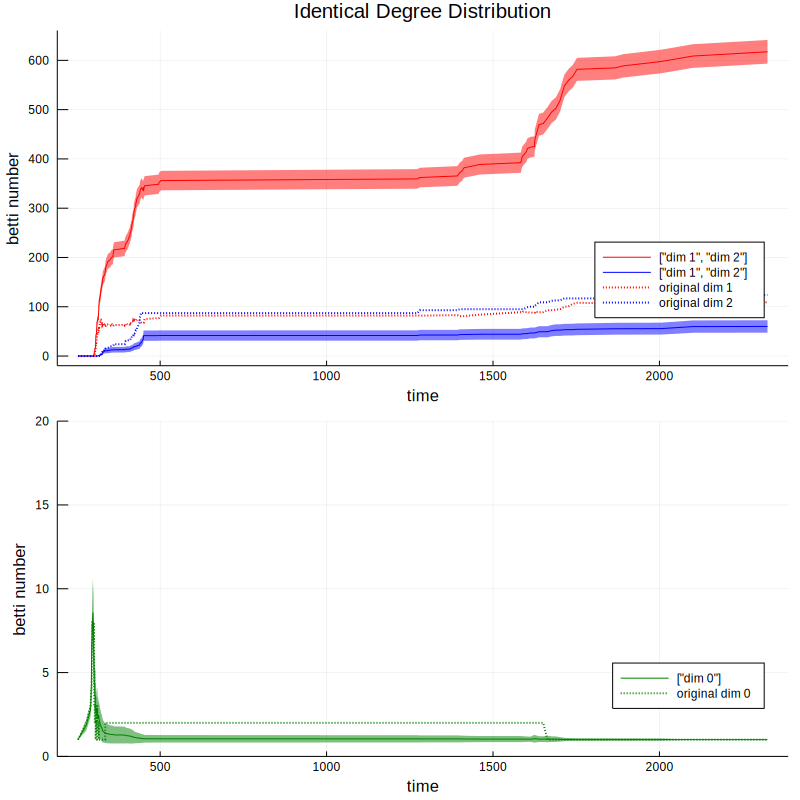

In [10]:
#plots the average of the random curves, which a strip covering +/- 1 std


p1 = plot(times[:,1], bettiMeans[:,2:3], ribbon = bettiStd[:,2:3], color = [:red :blue theme(:default)], legend=:bottomright , title = "Identical Degree Distribution", label = ["dim 1", "dim 2"],  xlabel = "time", ylabel = "betti number")
plot!(times[:,1], BettiCurves[:,2:3], line=(:dot,2), color = [:red :blue theme(:default)], label = [ "original dim 1" "original dim 2"])
p2 = plot(times[:,1], bettiMeans[:,1], ribbon = bettiStd[:,1], color = [:green theme(:default)], legend=:bottomright , label = ["dim 0"],  xlabel = "time", ylabel = "betti number", ylims = (0, 20))
plot!(times[:,1], BettiCurves[:,1], line=(:dot,2), label = "original dim 0", color = [:green theme(:default)])

plot(p1,p2, layout = (2,1), size = (800,800))

#savefig("rewiredTrials.pdf")

In [ ]:
#generate 1000 rewiring trials
nTrials = 1000
configurationTrials = zeros(279,279,nTrials)
fill!(configurationTrials, 3000)

#find set of all edges in the graph
degreeDistribution = Array{Int64, 1}(undef, 279)
for i in 1:279
    degree = 0
    
    for j in 1:279
        if j != i && birthSortedAdjacencyMatrix[i,j] < 3000
            degree += 1
        end
    end
    
    degreeDistribution[i] = degree
end


for k in 1:nTrials
    print(k, "  ")
    for i in 1:279
       configurationTrials[i,i,k] = labelsTimesPositionsType[i,2]
    end
    
    ddHolder = degreeDistribution[:]
    
    errorCounter = 0
    
   while sum(ddHolder) > 0
        
        initial = rand(1:279)
        terminal = rand(1:279)
        
        if ddHolder[initial] != 0 && ddHolder[terminal] != 0
            if configurationTrials[initial, terminal,k] == 3000
                
                max = maximum([initial, terminal])
                ddHolder[initial] -= 1
                ddHolder[terminal] -= 1
                configurationTrials[initial, terminal,k] = labelsTimesPositionsType[max, 2]
                configurationTrials[terminal, initial,k] = labelsTimesPositionsType[max, 2]
            end
            
        end
        
        errorCounter += 1
        
        if errorCounter == 10000
            errorCounter = 0
            fill!(configurationTrials[:,:,k], 3000)
            ddHolder = degreeDistribution[:]
            
            for i in 1:279
               configurationTrials[i,i,k] = labelsTimesPositionsType[i,2]
            end
        end
    end
end
print("output: configurationTrials, nTrials")

In [ ]:
#determine persistent homology of spatial growth

begin
randomCurves = pmap(i -> computeBarcodesNullModels(configurationTrials[:,:,i], times), 1:nTrials)
end
    
#organize this into a nicer format
rewiredBettiCurves = zeros(numValues,3,nTrials)

for k in 1:nTrials
    configurationBettiCurves[:,:,k] = randomCurves[k]
end
            
    
println("output: configurationBettiCurves")

In [ ]:
#computes average and standard deviation of nTrials copies
bettiMeans = zeros(numValues,3)
bettiStd = zeros(numValues,3)

for i in 1:numValues
    bettiMeans[i,1] = mean(configurationBettiCurves[i,1,:])
    bettiMeans[i,2] = mean(configurationBettiCurves[i,2,:])
    bettiMeans[i,3] = mean(configurationBettiCurves[i,3,:])
    
    bettiStd[i,1] = std(configurationBettiCurves[i,1,:])
    bettiStd[i,2] = std(configurationBettiCurves[i,2,:])
    bettiStd[i,3] = std(configurationBettiCurves[i,3,:])
end

print("output: bettiMeans, bettiStd")

In [ ]:
#plots the average of the random curves, which a strip covering +/- 1 std


p1 = plot(times[:,1], bettiMeans[:,2:3], ribbon = bettiStd[:,2:3], color = [:red :blue theme(:default)], legend=:bottomright , title = "Configurationj", label = ["dim 1", "dim 2"],  xlabel = "time", ylabel = "betti number")
plot!(times[:,1], BettiCurves[:,2:3], line=(:dot,2), color = [:red :blue theme(:default)], label = [ "original dim 1" "original dim 2"])
p2 = plot(times[:,1], bettiMeans[:,1], ribbon = bettiStd[:,1], color = [:green theme(:default)], legend=:bottomright , label = ["dim 0"],  xlabel = "time", ylabel = "betti number", ylims = (0, 20))
plot!(times[:,1], BettiCurves[:,1], line=(:dot,2), label = "original dim 0", color = [:green theme(:default)])

plot(p1,p2, layout = (2,1), size = (800,800))

savefig("configurationTrials.pdf")